In [ ]:
#for evaluate

In [ ]:
'''
실험은 여기서 진행하면 될거야
원래 run 함수 만들어서 한방에 돌아가도록 하려했는데 사용자한테 threshold 받아오려면 오히려 비효율적일것 같더라고
최종 목적은 웹이나 시각화 툴 혹은 python 시각화 라이브러리 이용하는 거니까 우선은 이 파일로 실험 진행하고 나중에 프로그램적으로 돌려야겠다 싶으면
그 때 만들어도 될 것 같다.

필요할 것 같은 함수들은 만들어 뒀는데 추가로 필수적인 함수 있으면 구현해서 사용하면 되고 기호에 맞게 수정해도 돼
그리고 함수 추가하거나 수정한 후에 PR 할때는 꼭 말해주고
'''

'\n실험은 여기서 진행하면 될거야\n원래 run 함수 만들어서 한방에 돌아가도록 하려했는데 사용자한테 threshold 받아오려면 오히려 비효율적일것 같더라고\n최종 목적은 웹이나 시각화 툴 혹은 python 시각화 라이브러리 이용하는 거니까 우선은 이 파일로 실험 진행하고 나중에 프로그램적으로 돌려야겠다 싶으면\n그 때 만들어도 될 것 같다.\n\n필요할 것 같은 함수들은 만들어 뒀는데 추가로 필수적인 함수 있으면 구현해서 사용하면 되고 기호에 맞게 수정해도 돼\n그리고 함수 추가하거나 수정한 후에 PR 할때는 꼭 말해주고\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# cd [your src path]
%cd /content/drive/MyDrive/bistelligence/BISTelligence/src

/content/drive/MyDrive/bistelligence/BISTelligence/src


In [3]:
%pip install pyod tensorflow shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 21.9 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=aef8325aa0617f6362855a41ea254b2aeab1ad09b86a11d85cef0d1296918f15
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [4]:
from sklearn.utils.validation import check_is_fitted
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import shap
from tensorflow.keras.models import load_model
import pandas as pd

     
import data.preprocessing as dp
import model.models as mm
import XAI.xai as xx

In [5]:
path = '/content/drive/MyDrive/bistelligence/BIS_data/BISTelligen_Project_Data.csv'
train_data, test_data = 0, 0
threshold = 0

trainer = mm.ModelTrain()

In [6]:
def SetData(scaled=True, key_num = -1):
  global train_data, test_data

  train_data, test_data = dp.GetPreprocessedData(path, scaled, key_num = key_num)

In [7]:
def GetModel(model_name='MCD', param_dict={}):
  '''
  [default value in 'ModelTrain' Class]
  param_dict={'contamination':0.01,
                     'novelty':True,
                     'random_state':42,
                     'n_conponents':1,
                     'cv_type':'full',
                     'momentum':0.9,
                     'learning_rate':0.03,
                     'epochs':100,
                     'patience':10}
  '''

  global trainer

  trainer.SetTrainer(train_data)
  trainer.SetParam(param_dict)
  model = trainer.GetTrainedModel(model_name)

  return model

In [8]:
def GetAnomalyScore(model=None):
  '''
  모델의 anomaly score return

  나중에 웹이나 시각화 툴로 health index 나타낼 때, (x,y)값 입력해야하는 경우 필요할 것 같아서 만듦.
  혹시 필요 없더라도 문제 없으니까 구현
  '''

  
  model_name = type(model).__name__
  if model_name == 'GaussianMixture':
    model_name = 'GMM'


  if model_name in ['MCD','LOF']:
    anomaly_score = model.decision_function(test_data)

  elif model_name in ['OCSVM','IForest']:
    anomaly_score = model.decision_function(test_data) + np.abs(np.min(model.decision_function(test_data)))
  elif model_name == 'GMM':
    anomaly_score = np.sum(-model._estimate_weighted_log_prob(test_data), axis = 1)
  else:
    reconstruction = model.predict(test_data)
    anomaly_score = np.mean(np.power(test_data-reconstruction,2),axis=1)
    

  return anomaly_score

In [9]:
def ShowHealthIndex(model = None, anomaly_score = None, scaled = True, key_num = 123456):
  '''
  GetAnomalyScore로 이상치 점수 받아온 후, health index plot을 도출
  png로 저장 혹은 단순 plot 도출
  '''
  #plt.rcParams['figure.figsize'] = (12, 8)
  model_name = type(model).__name__
  if model_name == 'Sequential':
    model_name = 'AutoEncoder'
  elif model_name == 'GaussianMixture':
    model_name = 'GMM'
  sns.scatterplot(range(len(anomaly_score)), anomaly_score)
  plt.title('{} health index in key {} '.format(model_name, key_num ,scaled), fontsize = 25)
  #plt.show()

In [10]:
def DoXAI(model = None, threshold = 0, plot_type = 0, sample_index = 0):
  '''
  더 잘맞는 함수 이름으로 바꿔도 괜찮고, 파라미터도 상황에 맞게 변경 가능
  (threshold를 입력받아야 XAI가 진행될 수도 있다고 생각되는데 그럴 경우, SetThreshold() 함수를 만들어서 threshold에 값 저장시킬 필요 있음.)
  XAI 폴더의 xai.py(가명)의 함수들을 실행시키는 함수
  
  xai.py(가명)의 함수들은 shap에서 지원하는 여러가지 plot을 그리고, png 파일로 XAI 폴더 내에 저장하는 동작으로 가정
  따라서 DoXAI()를 실행하면 XAI 폴더 내에 여러 plot png파일이 생성되는것을 생각하고 만듦
  '''
  model_name = type(model).__name__
  if model_name == 'GaussianMixture':
    model_name = 'GMM'

  # AutoEncoder
  if model_name == 'Sequential':
    model_name = 'AutoEncoder'
    score = GetAnomalyScore(model)
    #shap_values_all = xx.AutoEncoderSHAP(threshold_to_explain = threshold).explain_unsupervised_data(train_data, test_data, model)
    exp_model= xx.AutoEncoderSHAP(threshold_to_explain=threshold, reconstruction_error_percent=0.9 ,shap_values_selection = 'constant')
    shap_values_all = exp_model.explain_unsupervised_data(x_train=train_data, 
                                                                   x_explain=test_data,
                                                                   autoencoder=model,
                                                                   return_shap_values=True)
    
    print(shap_values_all)

    if plot_type == 0:    
      col = shap_values_all.sum().sort_values().index[0]
      shap_values_all.drop([col], axis=1, inplace = True)  
      shap.summary_plot(shap_values_all.values, shap_values_all.columns, plot_type = "bar", show=False)
      plt.title('{} summary_plot about {} in key{}'.format(model_name, col[0] ,i), fontsize = 20)


    elif plot_type == 1:
      shap_values = shap_values_all.iloc[sample_index]
      col = shap_values[shap_values == -1].index
      shap_values.drop(col, inplace = True)
      print(shap_values.index)
      reconstruction = pd.DataFrame(model.predict(train_data),columns = train_data.columns)

      # mse 가장 큰(shap value 정확하지 않은) 변수 제거 후 expected value 계산
      train_data.drop(col, axis=1, inplace = True)
      reconstruction.drop(col, axis=1, inplace = True)
      error = np.mean(np.power(train_data-reconstruction,2),axis=1)
      expected_value = np.mean(error)

      shap.force_plot(expected_value, shap_values = shap_values.values,feature_names = shap_values.index,show = False,  matplotlib = True)
      plt.title('{} force_plot about {} in key{}'.format(model_name, col[0], i), fontsize = 20)

    plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig('XAI/plot/{}_key{}_type{}.png'.format(model_name, i, plot_type), bbox_inches = 'tight', pad_inches=0.1)
    plt.show()

  # Other Models
  else:
    score = GetAnomalyScore(model)
    shap_values_all, explainer = xx.OtherModelSHAP(model).novelty_contribution(train_data, test_data, score, threshold)
    if plot_type == 0:
      shap.summary_plot(shap_values_all.values, shap_values_all.columns, plot_type = "bar", show=False)
      plt.title('{} summary_plot in key{}'.format(model_name, i), fontsize = 20)
    elif plot_type == 1:
      print(explainer.expected_value)
      shap.force_plot(explainer.expected_value, shap_values = shap_values_all.values[0],feature_names = shap_values_all.columns,show = False,  matplotlib = True)
      plt.title('{} force_plot in key{}'.format(model_name, i), fontsize = 20)
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.savefig('XAI/plot/{}_key{}_type{}.png'.format(model_name, i, plot_type), bbox_inches = 'tight', pad_inches=0.1)
    plt.show()
     

In [11]:
best_path = '/content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model'

In [12]:
# model.saved_model 폴더에 모델 저장
def SaveBestModel(model, key_num = 0):
  model_name = type(model).__name__
  if model_name == 'GaussianMixture':
    model_name = 'GMM'

  #AutoEncoder
  if model_name =='Sequential':
    file = 'AE_key' + str(key_num) + '.h5'
    filename = '/'.join([best_path, file])
    model.save(filename)
    print('model saved in PATH : {}'.format(filename))

  #Other Models
  else:
    file = model_name + '_key' +str(key_num)
    filename = '/'.join([best_path, file])
    #'_'.join(['best', type(model).__name__])
    joblib.dump(model, filename)
    print('model saved in PATH : {}'.format(filename))

In [13]:
# model.saved_model 폴더에서 모델 불러옴
def LoadBestModel(model_name, key_num = 0):
  
  #AutoEncoder
  if model_name =='AE':
    file = 'AE_key' + str(key_num) + '.h5'
    filename = '/'.join([best_path, file])
    model = load_model(filename)
    print('model load from PATH : {}'.format(filename))

  #Other Models
  else:
    file = model_name + '_key' +str(key_num)
    filename = '/'.join([best_path, file])
    model = joblib.load(filename)
    print('model load from PATH : {}'.format(filename))
    
  return model

In [14]:
SetData()

# MCD 

1.5072526117016323
1.447318162093038
1.2798603779844
1.5019395061847354
1.0480375399601738
1.2792415145907388


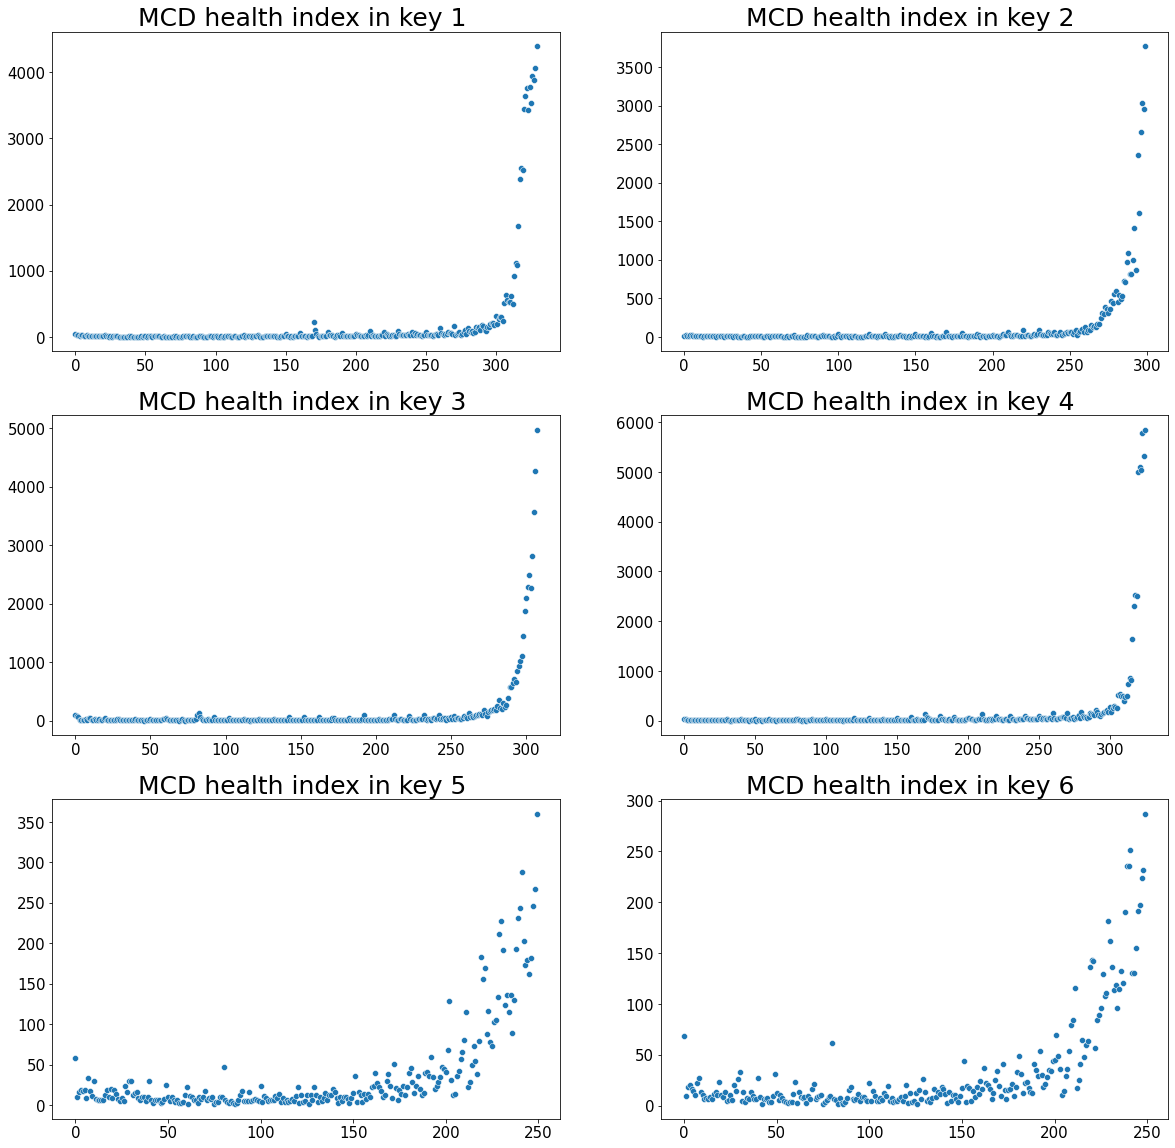

In [ ]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'MCD')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

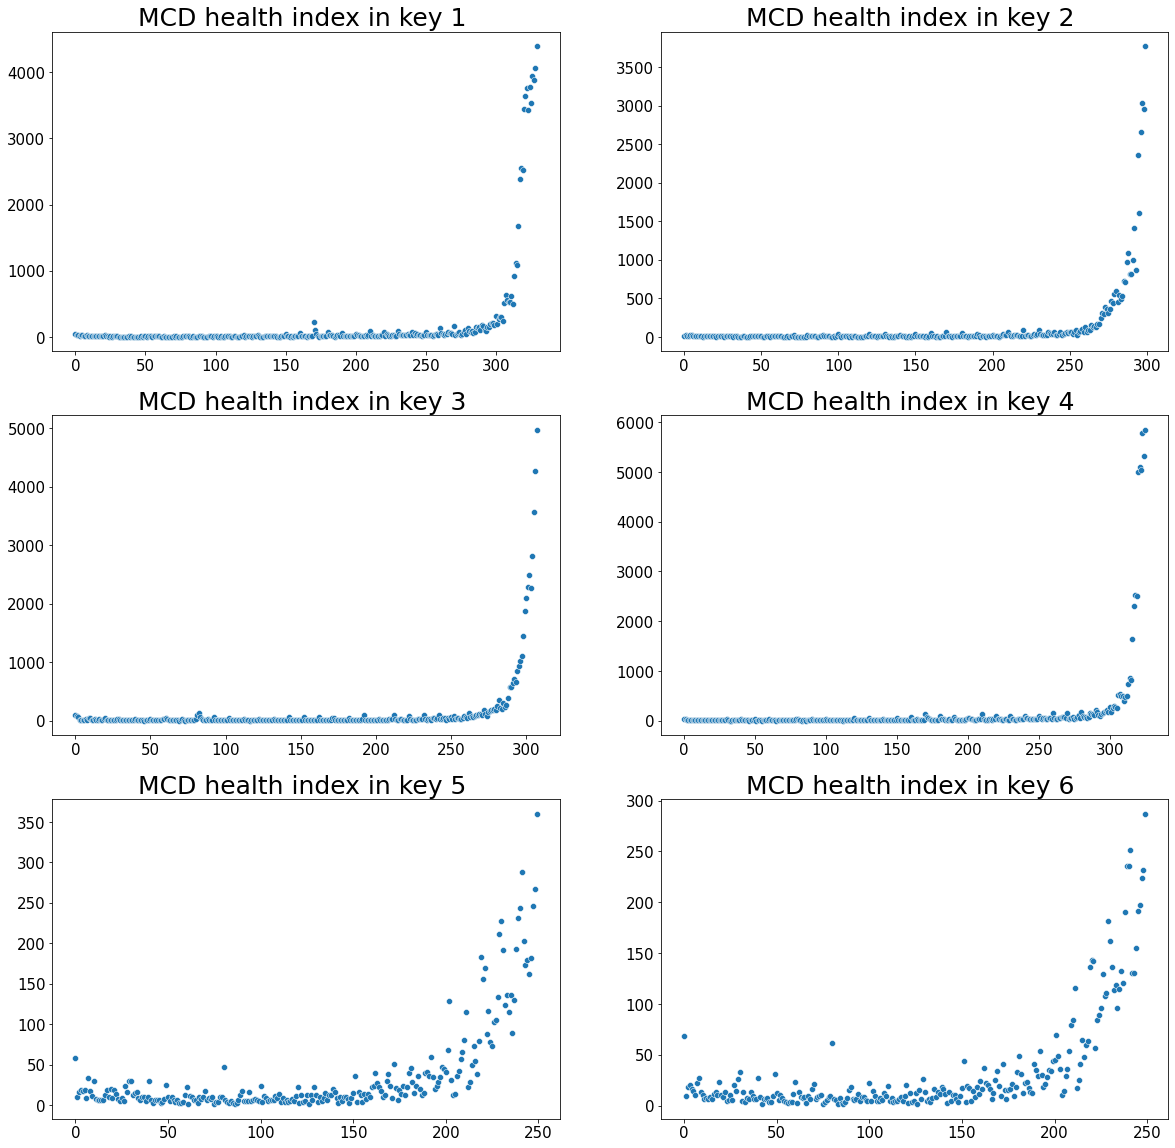

In [ ]:
# scale X
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'MCD')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

# LOF

LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)


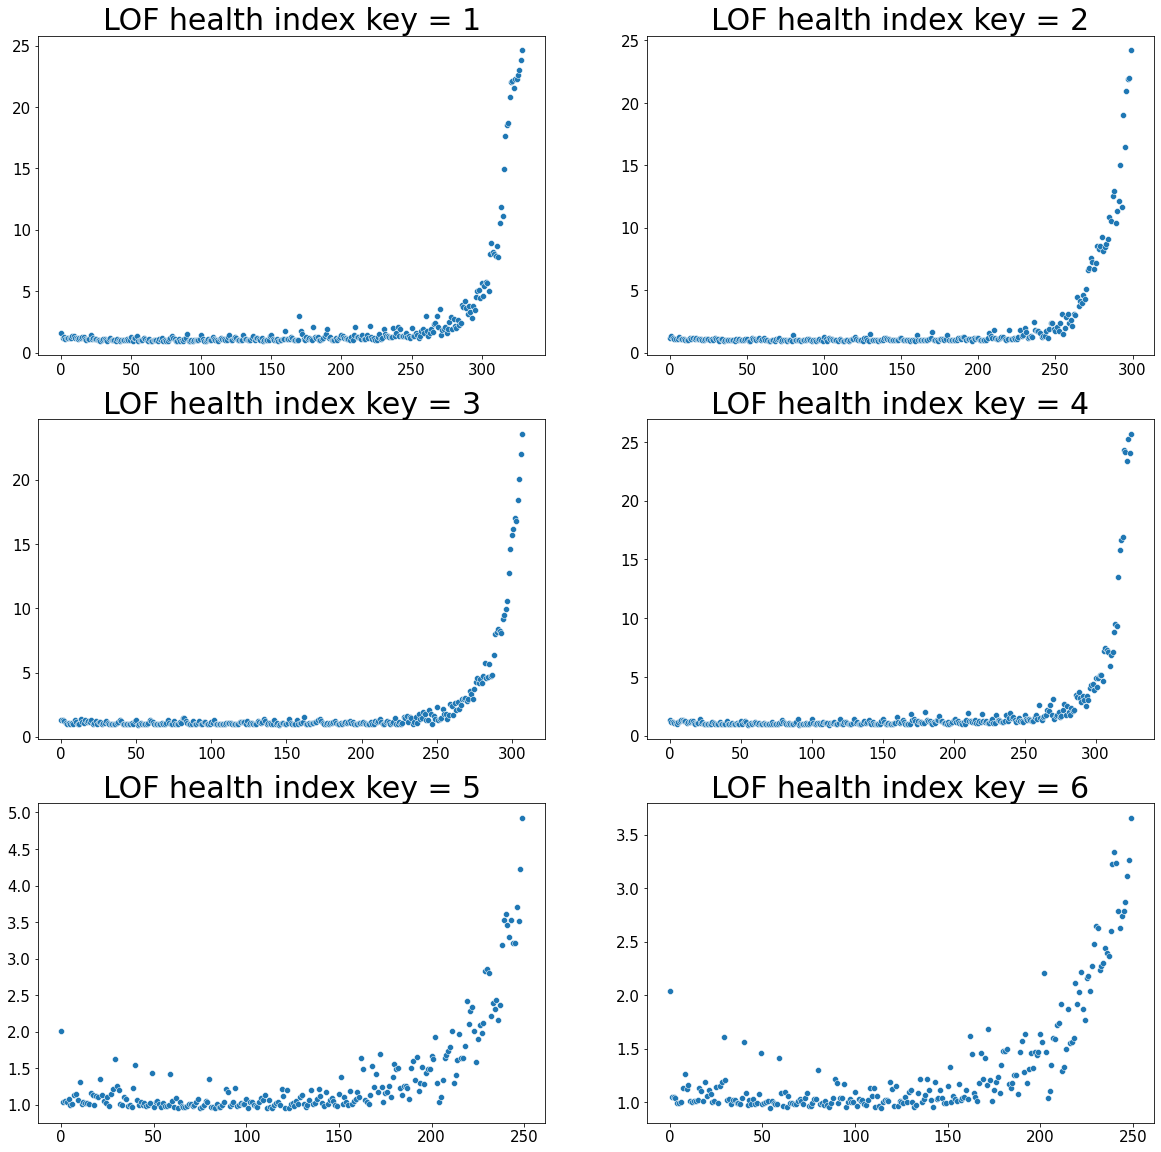

In [ ]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'LOF',param_dict = {'n_neighbors':20})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

LOF(algorithm='auto', contamination=0.01, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=30, novelty=True, p=2)


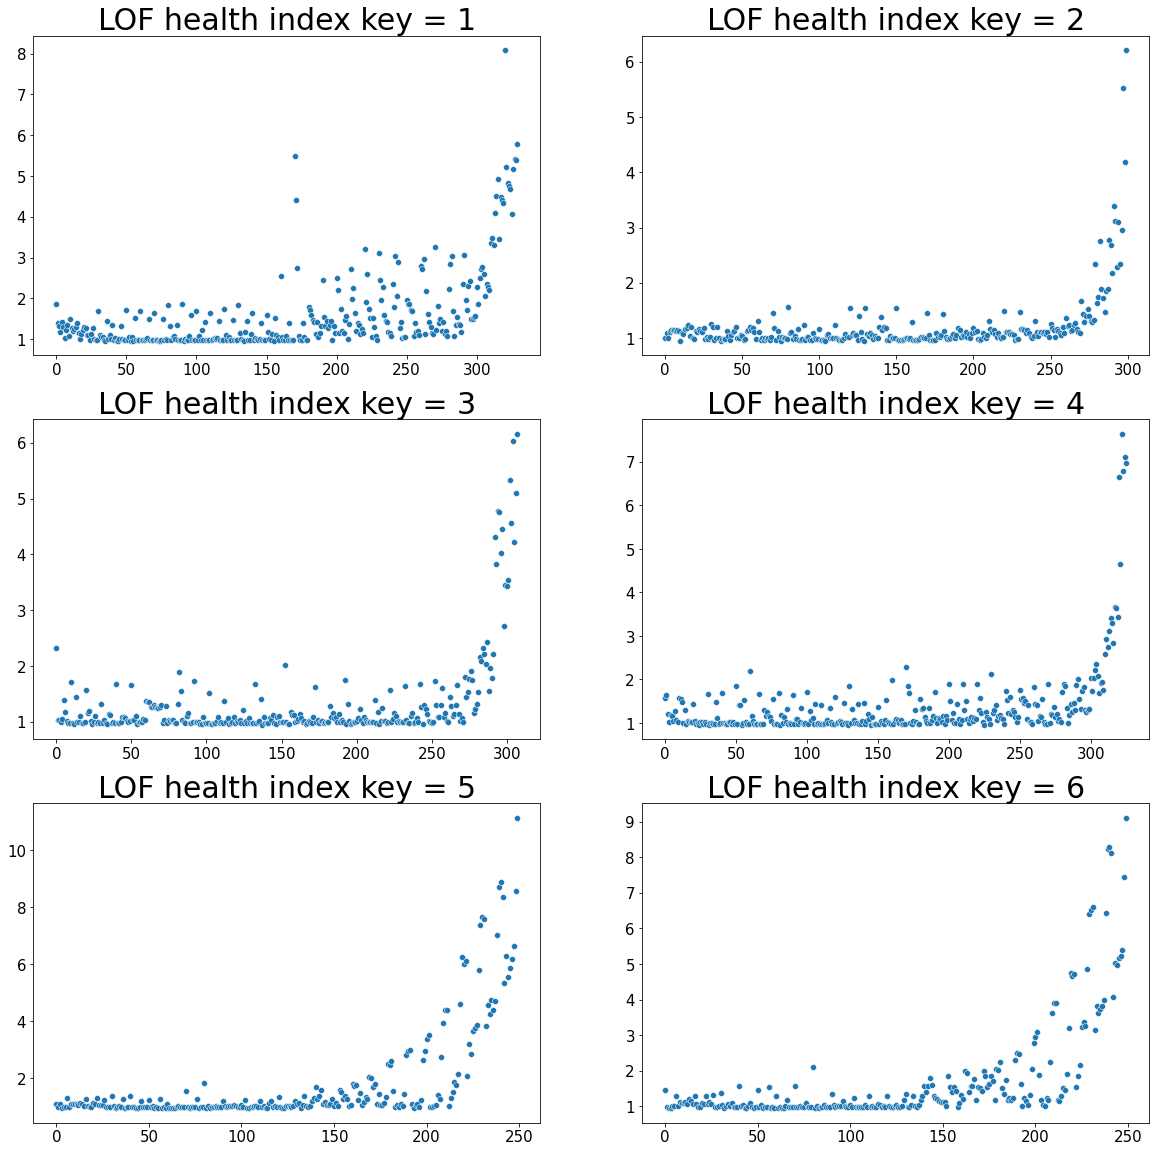

In [ ]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'LOF', param_dict = {'n_neighbors': 30})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# OCSVM

0.0
0.0
0.0
0.0
0.0
0.0
OCSVM(cache_size=200, coef0=0.0, contamination=0.01, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
   verbose=False)


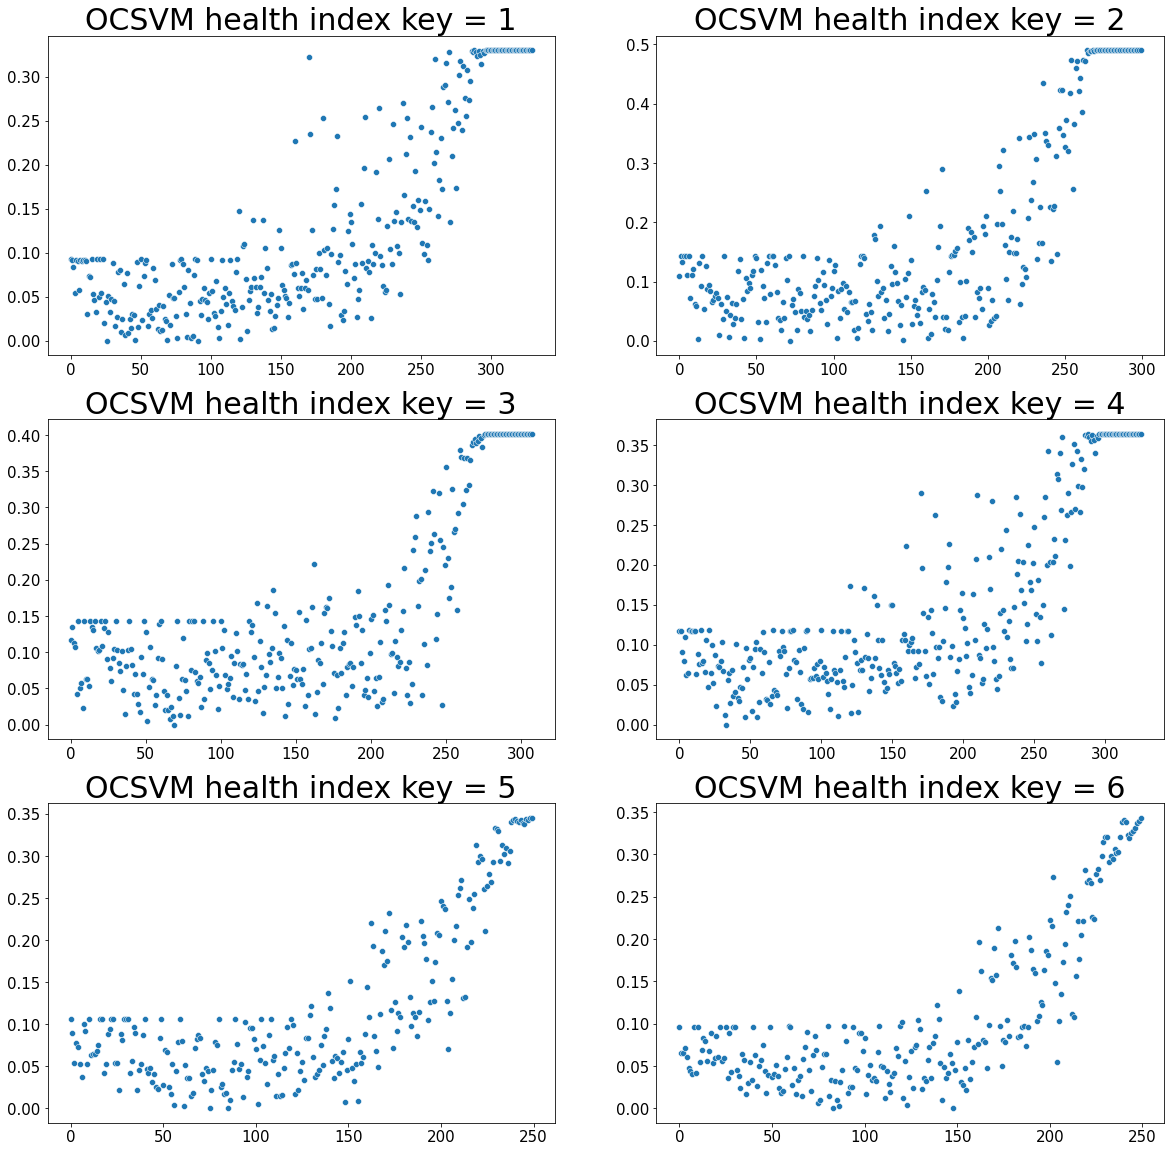

In [ ]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'OCSVM')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

OCSVM(cache_size=200, coef0=0.0, contamination=0.01, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.01, shrinking=True, tol=0.001,
   verbose=False)


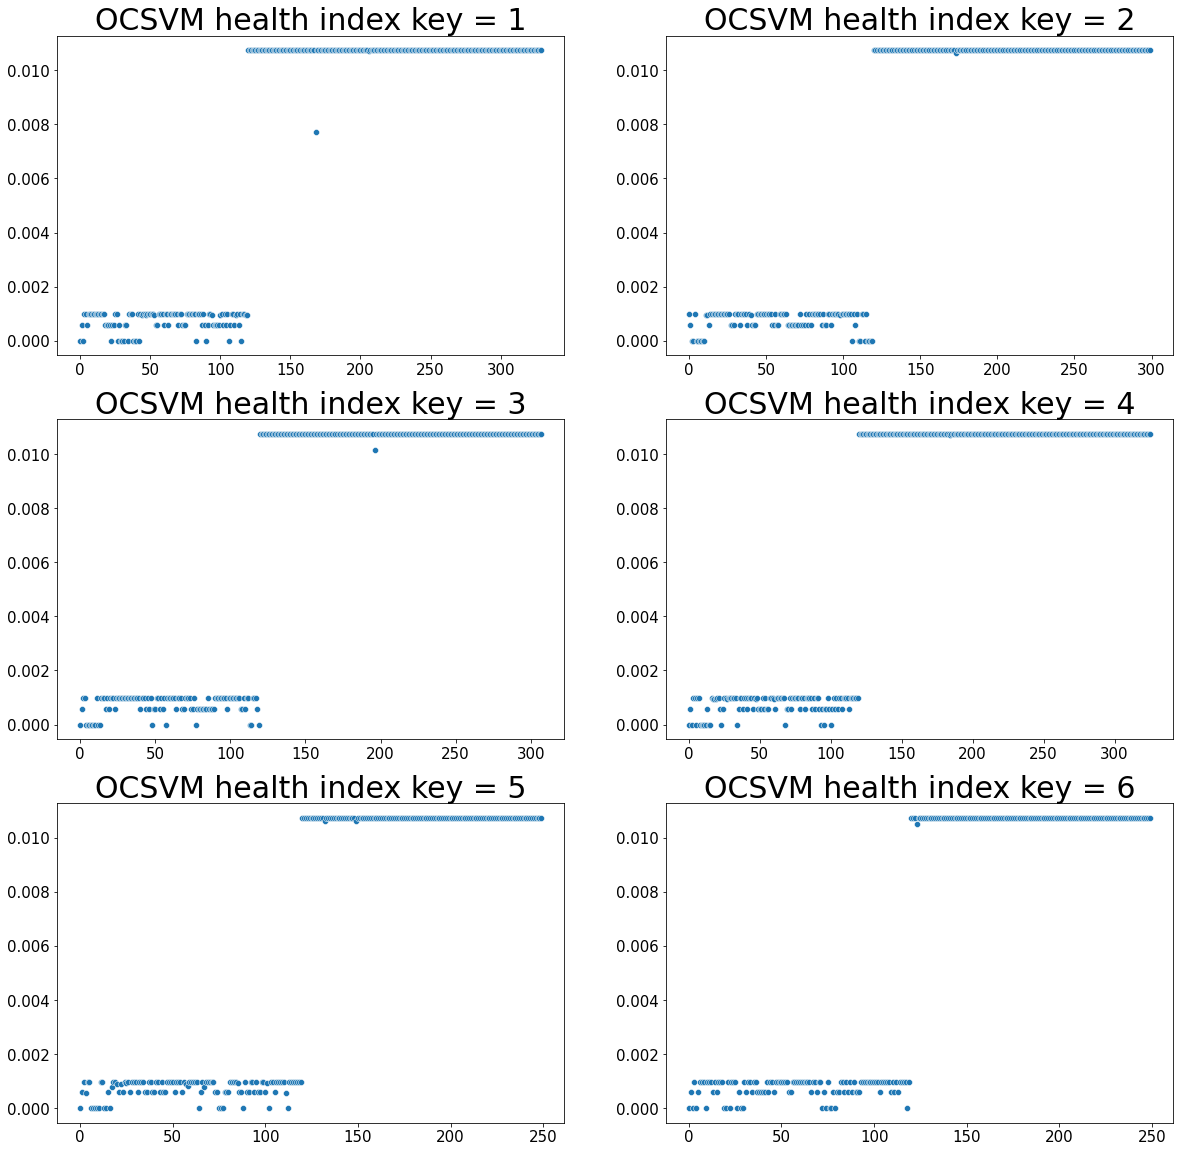

In [ ]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'OCSVM')
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# GMM

14.092919875994323
13.4198234457359
8.448546548107952
13.349549639602376
13.112070299500715
13.55887505842536
GaussianMixture(n_components=2)


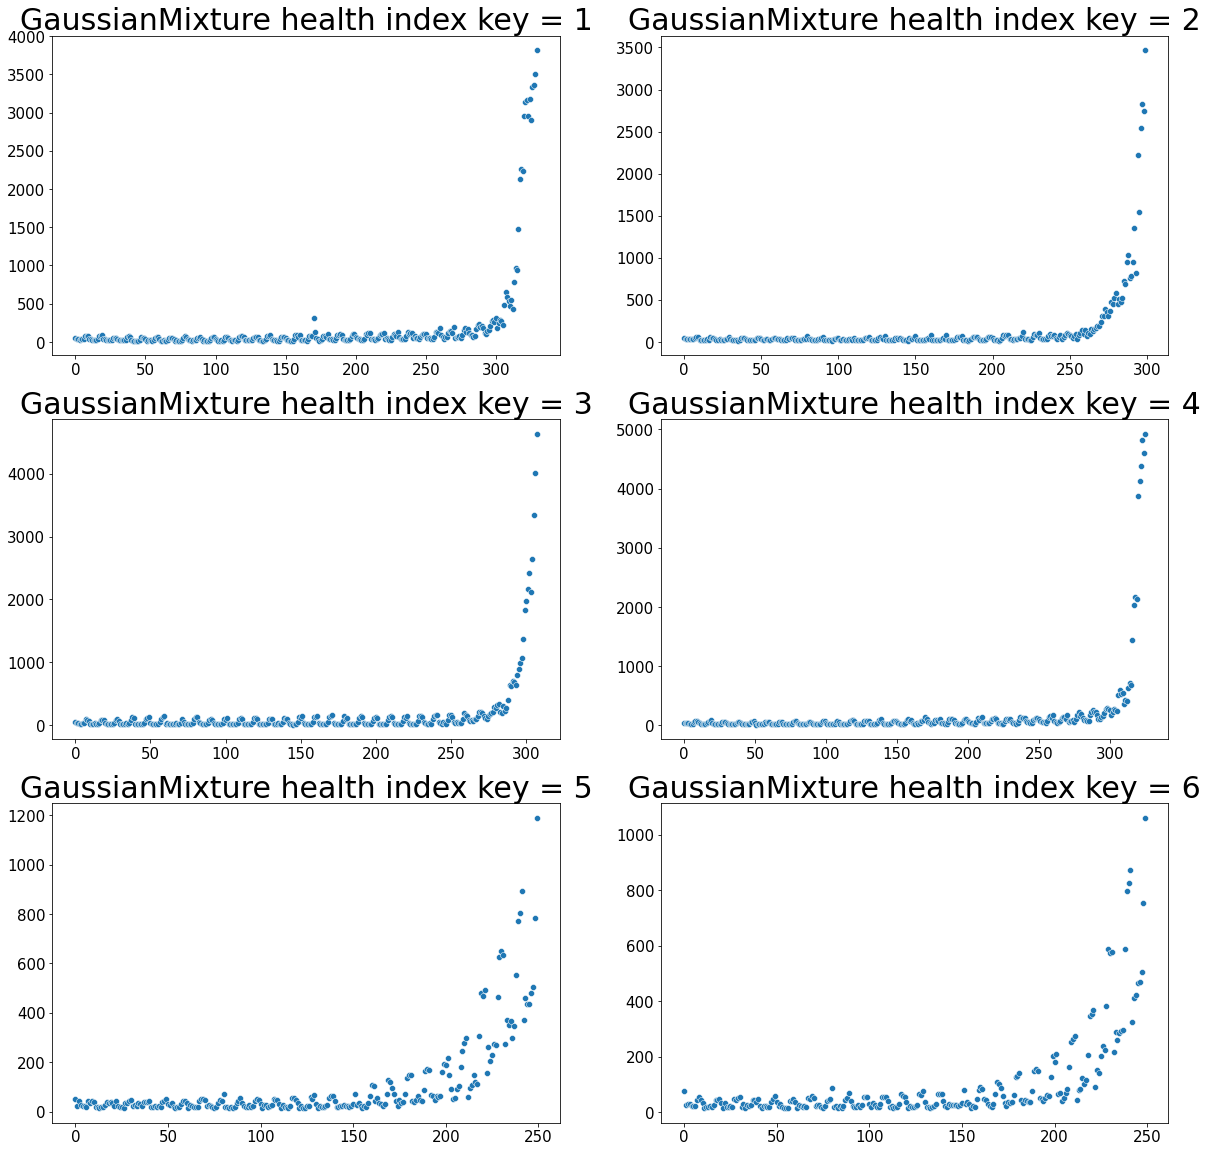

In [16]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'GMM', param_dict = {'n_components': 2, 'covariance_type': 'full'})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    print(np.min(score))
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

GaussianMixture(n_components=3)


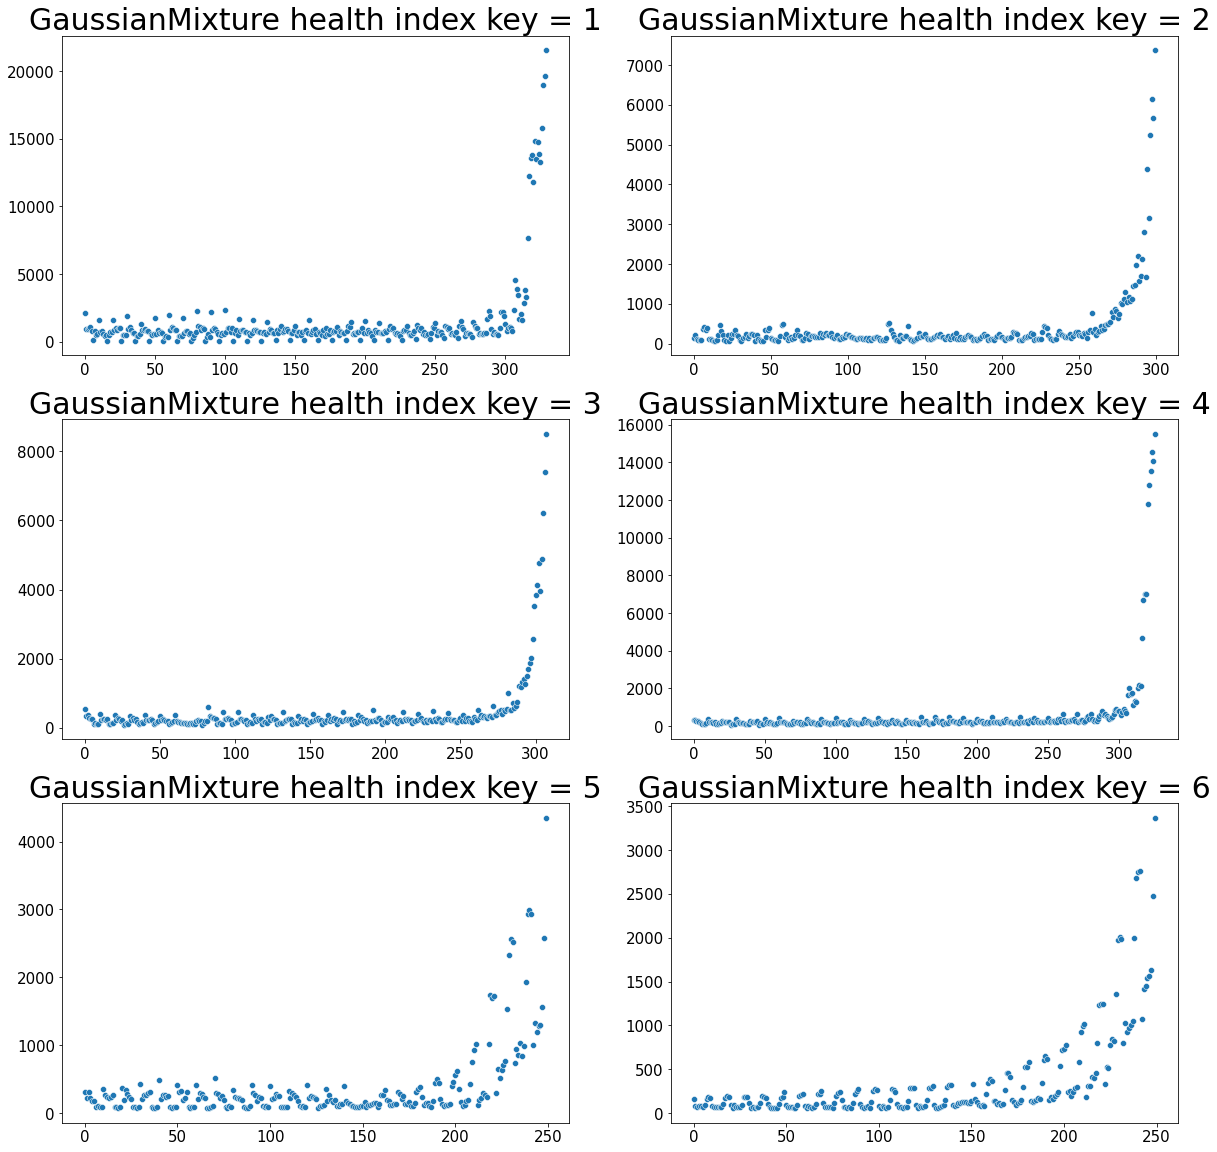

In [ ]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'GMM', param_dict = {'n_components':3, 'covariance_type': 'full'})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# Isolation Forest

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=200, n_jobs=1,
    random_state=None, verbose=0)


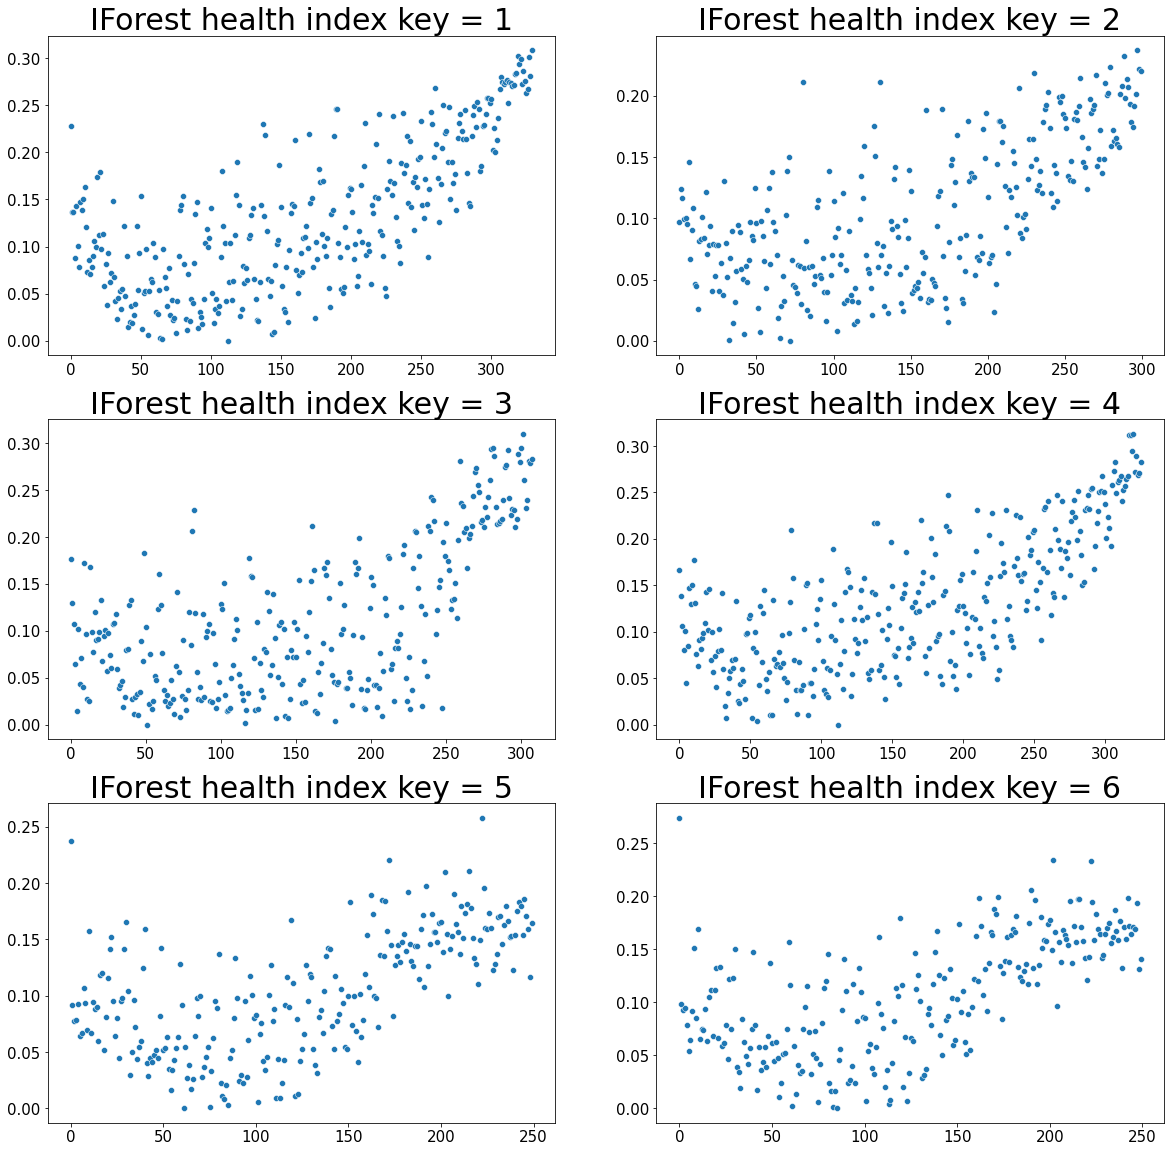

In [ ]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'IForest', param_dict = {'n_estimators': 200})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=200, n_jobs=1,
    random_state=None, verbose=0)


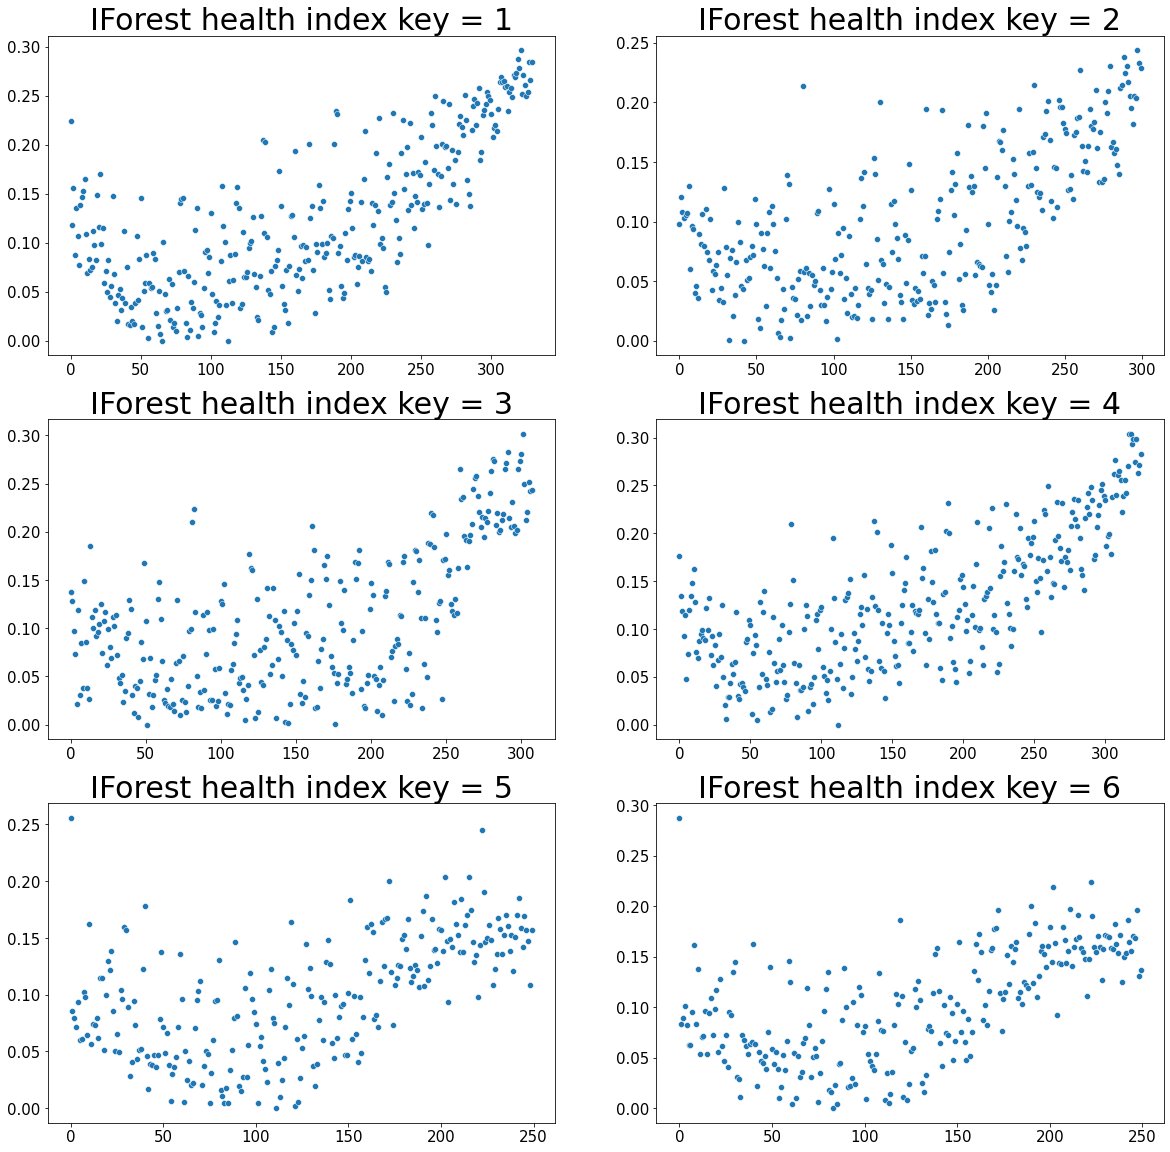

In [ ]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'IForest', param_dict = {'n_estimators': 200})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('{} health index key = {}'.format(model_name, i),fontsize=30)
print(model)

# AutoEncoder

model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key1.h5
11/11 [==============================] - 0s 2ms/step
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key2.h5
10/10 [==============================] - 0s 4ms/step
Epoch 141: early stopping
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key3.h5
10/10 [==============================] - 0s 2ms/step
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key4.h5
11/11 [==============================] - 0s 2ms/step
Epoch 164: early stopping
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key5.h5
8/8 [==============================] - 0s 2ms/step
Epoch 106: early stopping
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key6.h5
8/8 [========================

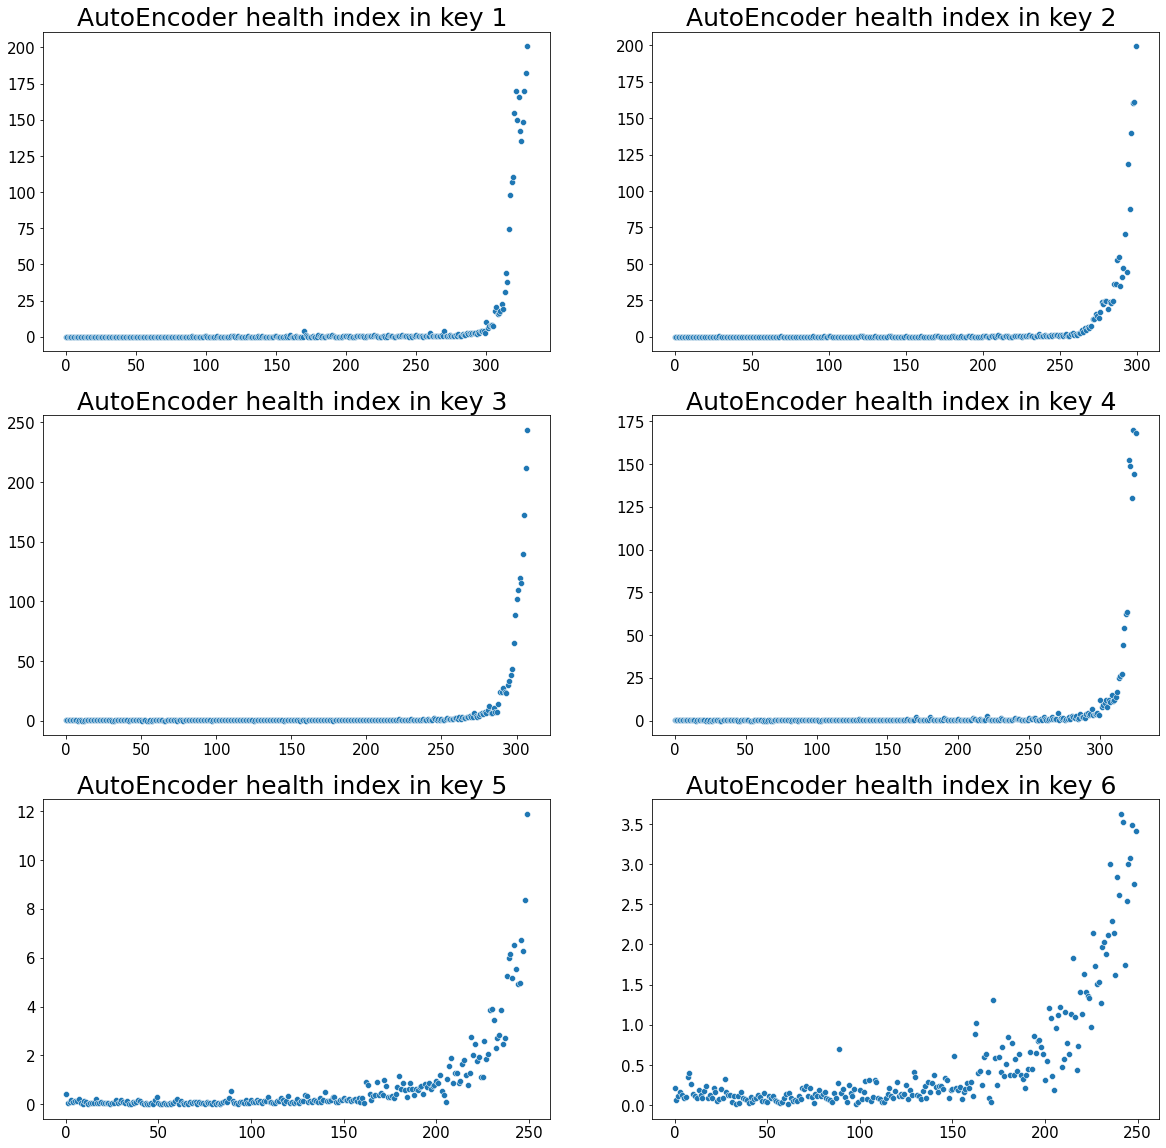

In [15]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = GetModel(model_name = 'AE', param_dict = {'momentum':0.6, 'learning_rate':0.03, 'patience':50,'epochs':200})
    SaveBestModel(model, key_num = i)
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
print(model)

Epoch 24: early stopping
11/11 [==============================] - 0s 2ms/step
Epoch 22: early stopping
10/10 [==============================] - 0s 2ms/step
Epoch 26: early stopping
10/10 [==============================] - 0s 2ms/step
Epoch 23: early stopping
11/11 [==============================] - 0s 2ms/step
Epoch 23: early stopping
8/8 [==============================] - 0s 2ms/step
Epoch 23: early stopping
8/8 [==============================] - 0s 3ms/step


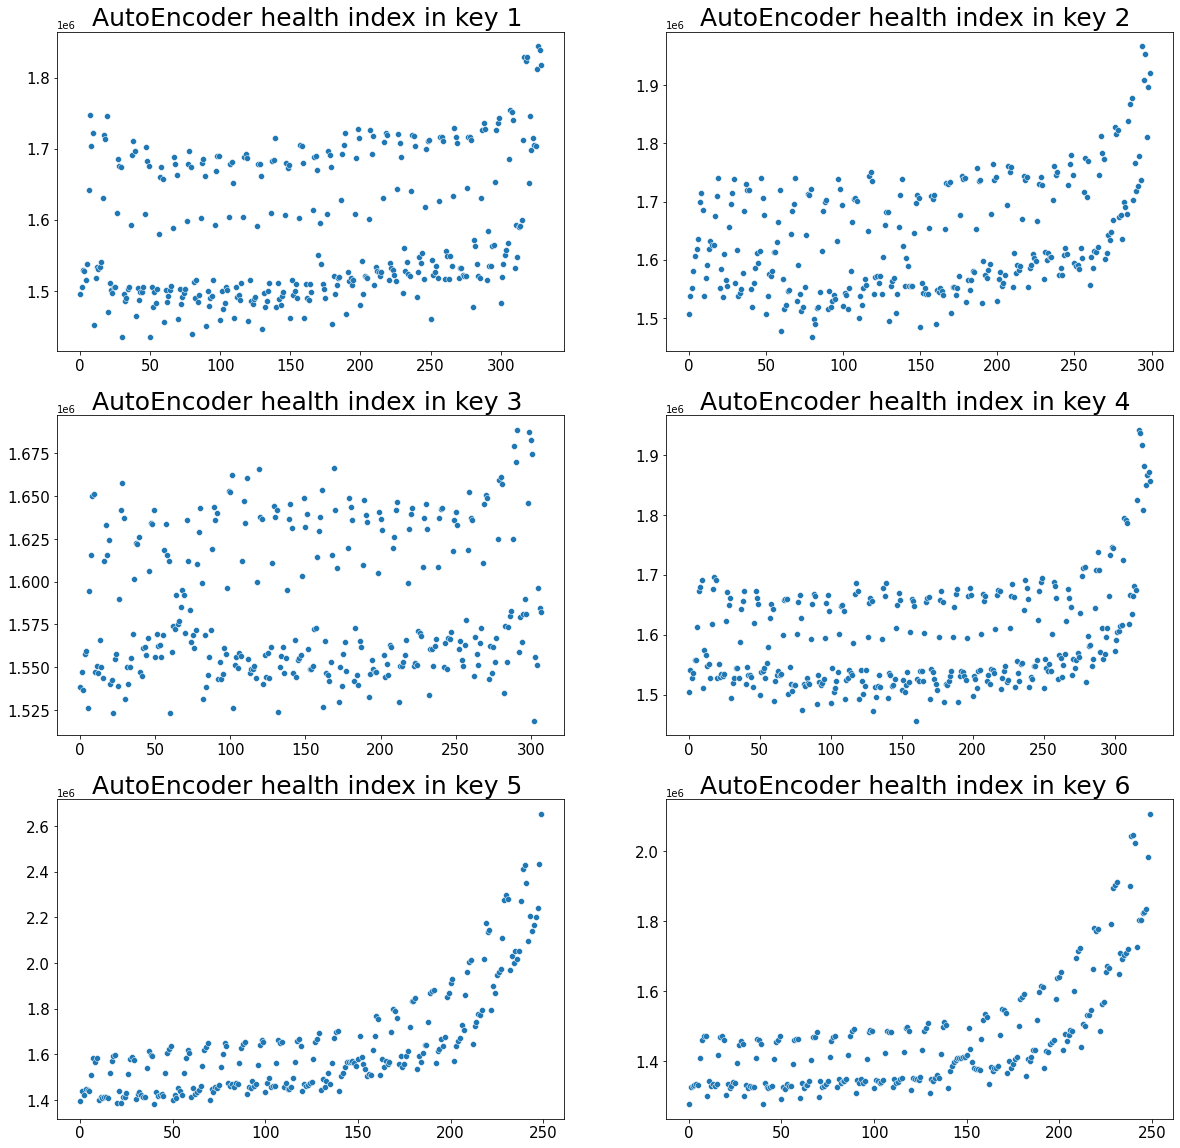

In [ ]:
# scale x
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(scaled = False, key_num = i)
    model = GetModel(model_name = 'AE', param_dict = {'momentum': 0.6, 'learning_rate': 0.03,'patience':20})
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
print(model)

# XAI

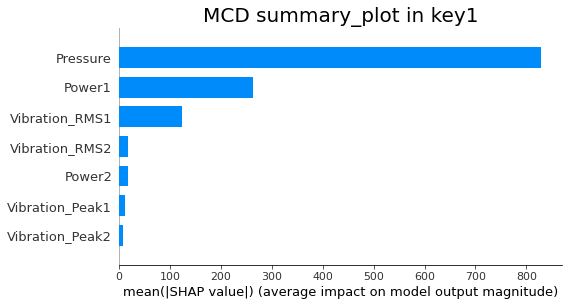

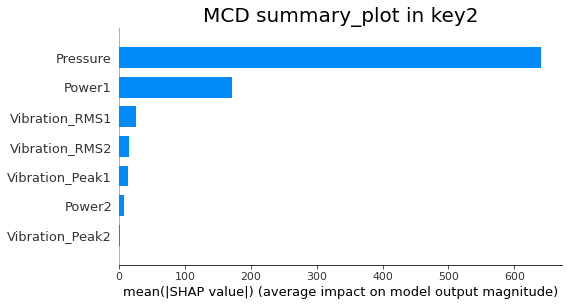

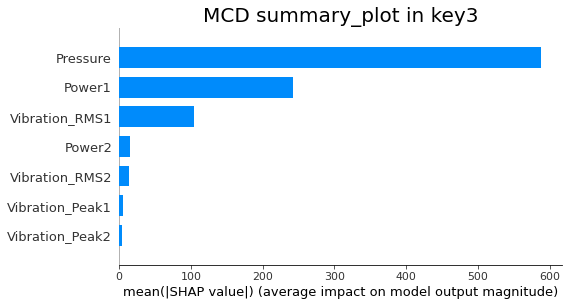

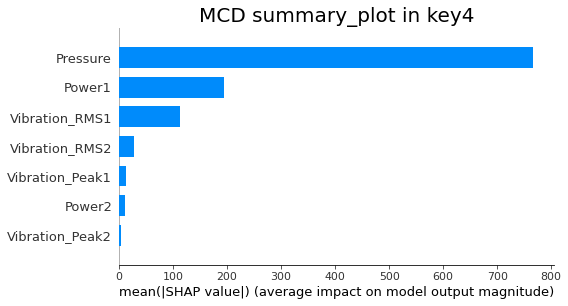

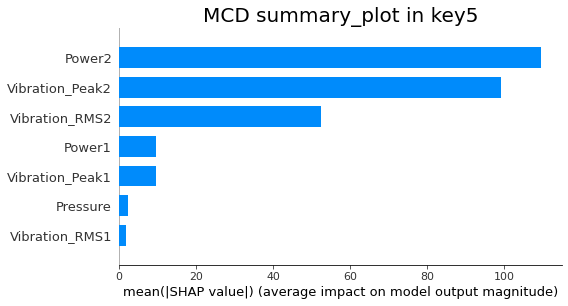

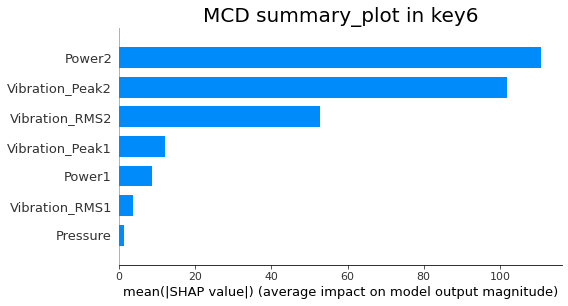

In [ ]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'MCD')
  DoXAI(model=model, threshold = 100, plot_type = 0)

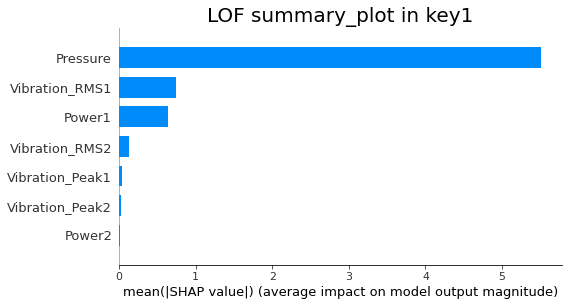

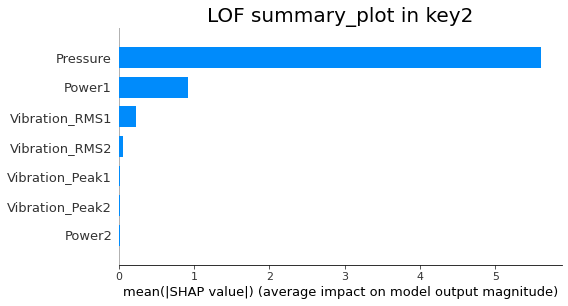

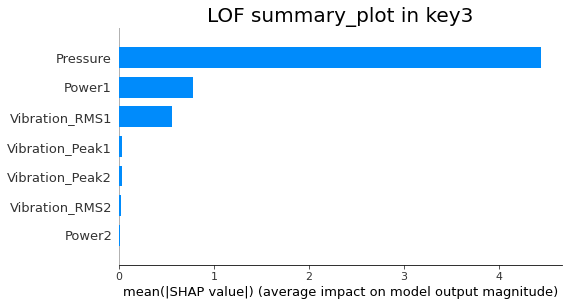

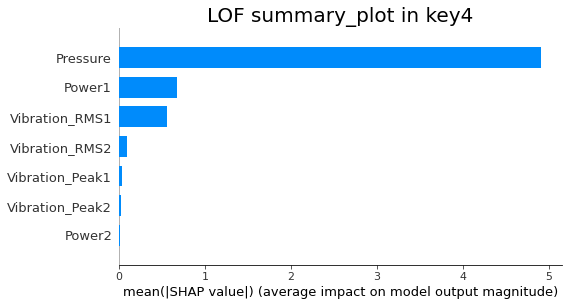

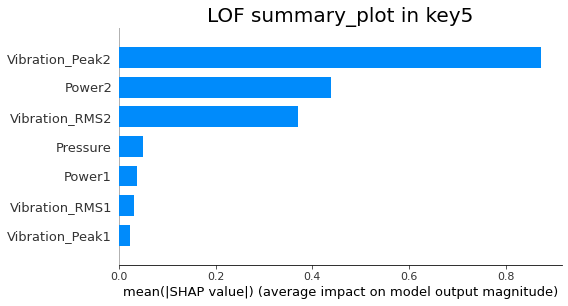

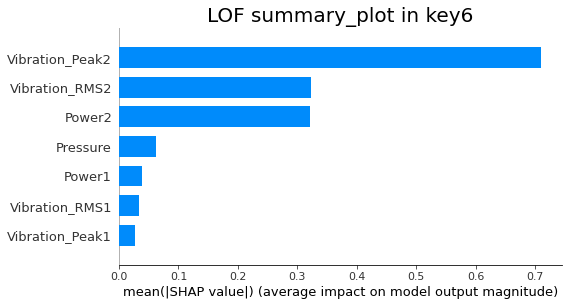

In [ ]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'LOF')
  DoXAI(model=model, threshold = 2, plot_type = 0)

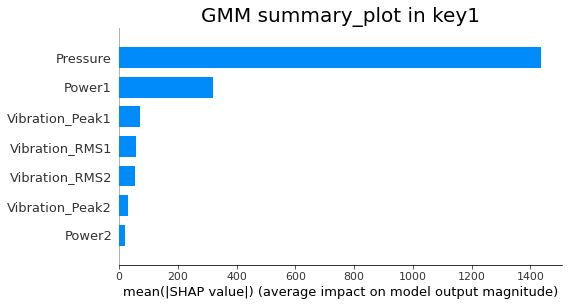

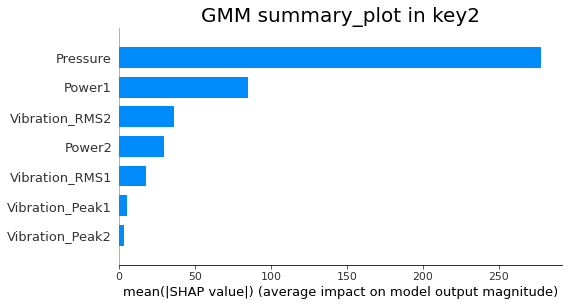

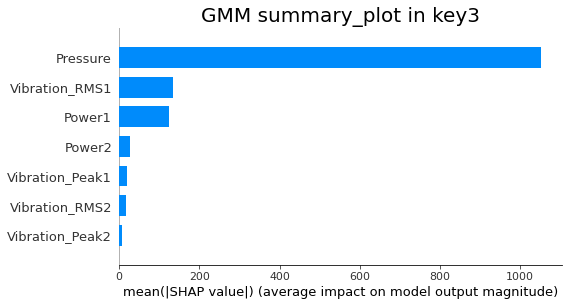

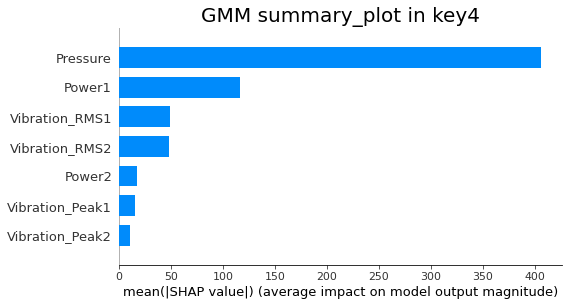

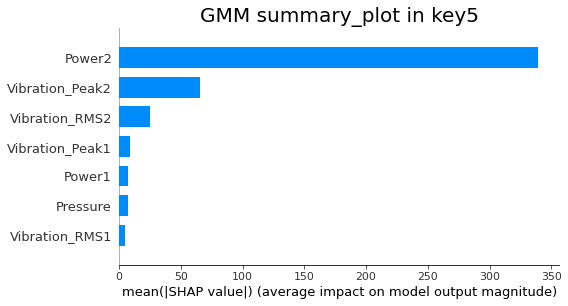

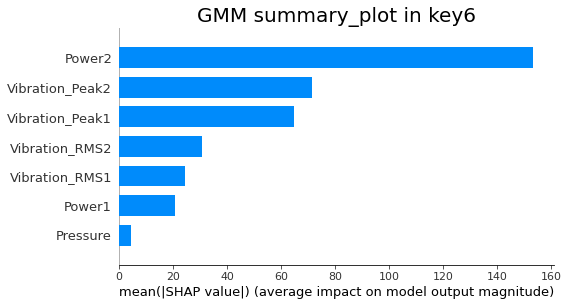

In [ ]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'GMM', param_dict = {'n_components':3})
  DoXAI(model=model, threshold = 100, plot_type = 0)

Epoch 11: early stopping
11/11 [==============================] - 0s 3ms/step
329
473/473 [==============================] - 1s 2ms/step
328
473/473 [==============================] - 2s 3ms/step
321
473/473 [==============================] - 1s 2ms/step
323
473/473 [==============================] - 1s 2ms/step
327
473/473 [==============================] - 1s 2ms/step
320
473/473 [==============================] - 1s 2ms/step
326
473/473 [==============================] - 1s 2ms/step
324
473/473 [==============================] - 1s 2ms/step
322
473/473 [==============================] - 1s 2ms/step
325
473/473 [==============================] - 1s 2ms/step
319
473/473 [==============================] - 1s 2ms/step
318
473/473 [==============================] - 1s 2ms/step
317
473/473 [==============================] - 1s 2ms/step
316
473/473 [==============================] - 1s 2ms/step
     Pressure  Vibration_RMS1    Power1  Vibration_RMS2  Vibration_Peak1  \
329 -1.000000       

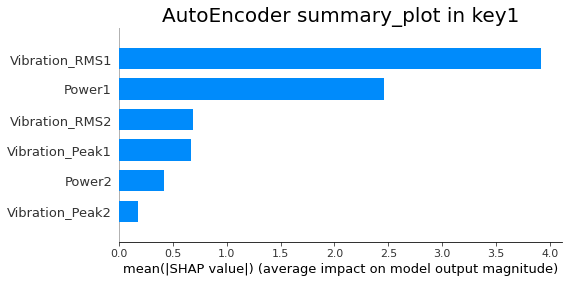

Epoch 11: early stopping
10/10 [==============================] - 0s 2ms/step
299
473/473 [==============================] - 1s 2ms/step
298
473/473 [==============================] - 1s 2ms/step
297
473/473 [==============================] - 1s 2ms/step
296
473/473 [==============================] - 1s 2ms/step
294
473/473 [==============================] - 1s 2ms/step
     Pressure    Power1  Vibration_RMS1  Vibration_Peak1  Vibration_RMS2  \
299        -1  3.112115        2.770243         0.556487        0.389551   
298        -1  2.393356        2.456550         0.461396        0.392912   
297        -1  2.472635        2.070967         0.565960        0.396152   
296        -1  2.113146        1.515488         0.338239        0.257729   
294        -1  2.152140        0.953395         0.152154        0.157450   

       Power2  Vibration_Peak2  
299  0.035407         0.000969  
298  0.030653         0.041495  
297  0.089766         0.006849  
296  0.149439         0.005452  
294  

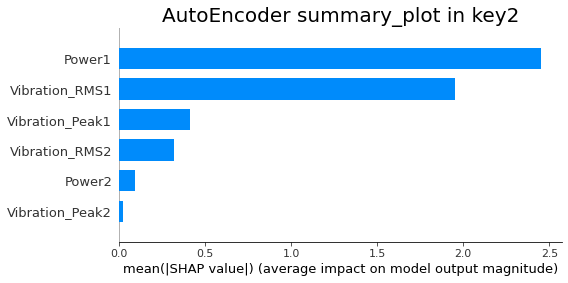

Epoch 12: early stopping
10/10 [==============================] - 0s 3ms/step
307
473/473 [==============================] - 1s 2ms/step
306
473/473 [==============================] - 1s 2ms/step
305
473/473 [==============================] - 1s 2ms/step
302
473/473 [==============================] - 1s 2ms/step
304
473/473 [==============================] - 1s 3ms/step
301
473/473 [==============================] - 1s 2ms/step
300
473/473 [==============================] - 1s 2ms/step
299
473/473 [==============================] - 1s 2ms/step
303
473/473 [==============================] - 1s 2ms/step
298
473/473 [==============================] - 1s 2ms/step
297
473/473 [==============================] - 1s 2ms/step
     Vibration_RMS1  Pressure  Vibration_Peak1    Power1  Vibration_RMS2  \
307       -1.000000  9.370123         1.285239  0.439439        0.220326   
306       -1.000000  9.275083         1.623961  0.055697        0.215993   
305       -1.000000  8.844173         1.53077

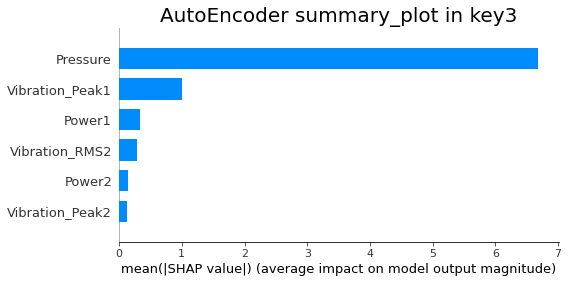

Epoch 11: early stopping
11/11 [==============================] - 0s 3ms/step
323
473/473 [==============================] - 1s 2ms/step
325
473/473 [==============================] - 1s 2ms/step
321
473/473 [==============================] - 1s 2ms/step
320
473/473 [==============================] - 1s 2ms/step
324
473/473 [==============================] - 1s 2ms/step
322
473/473 [==============================] - 1s 2ms/step
318
473/473 [==============================] - 1s 2ms/step
319
473/473 [==============================] - 1s 2ms/step
317
473/473 [==============================] - 1s 2ms/step
     Pressure    Power1  Vibration_RMS1  Vibration_RMS2  Vibration_Peak1  \
323        -1  8.381713        2.752565        0.735821         0.190384   
325        -1  8.001937        3.386999        0.685058         1.495791   
321        -1  5.896812        3.243909        0.979338         0.475994   
320        -1  3.157111        4.726945        0.893723         1.280048   
324        

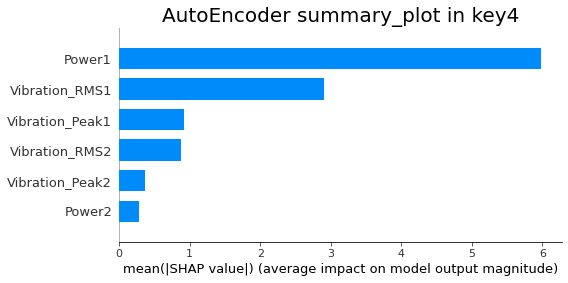

In [ ]:
for i in range(1, 5):
  SetData(key_num = i)
  model = GetModel(model_name = 'AE',param_dict = {'momentum': 0.9, 'learning_rate': 0.03,'patience':10})
  DoXAI(model=model, threshold = 100, plot_type = 0)

Epoch 11: early stopping
8/8 [==============================] - 0s 4ms/step
249
473/473 [==============================] - 1s 2ms/step
248
473/473 [==============================] - 1s 2ms/step
241
473/473 [==============================] - 1s 2ms/step
240
473/473 [==============================] - 1s 2ms/step
239
473/473 [==============================] - 1s 2ms/step
246
473/473 [==============================] - 1s 2ms/step
243
473/473 [==============================] - 1s 2ms/step
247
473/473 [==============================] - 1s 2ms/step
238
473/473 [==============================] - 1s 2ms/step
242
473/473 [==============================] - 1s 2ms/step
244
473/473 [==============================] - 1s 2ms/step
245
473/473 [==============================] - 1s 2ms/step
231
473/473 [==============================] - 1s 2ms/step
230
473/473 [==============================] - 1s 2ms/step
229
473/473 [==============================] - 1s 2ms/step
     Vibration_Peak2  Vibration_RMS2   

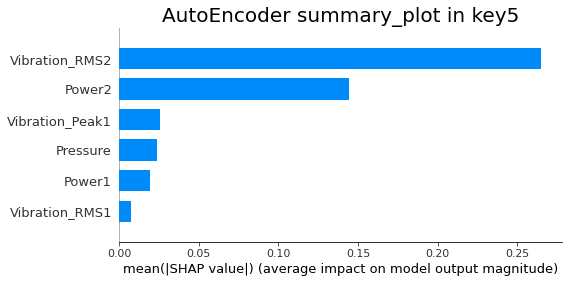

Epoch 11: early stopping
8/8 [==============================] - 0s 2ms/step
249
473/473 [==============================] - 2s 3ms/step
240
473/473 [==============================] - 1s 2ms/step
239
473/473 [==============================] - 1s 2ms/step
248
473/473 [==============================] - 1s 2ms/step
241
473/473 [==============================] - 1s 2ms/step
247
473/473 [==============================] - 1s 2ms/step
230
473/473 [==============================] - 1s 2ms/step
231
473/473 [==============================] - 1s 2ms/step
     Vibration_Peak2    Power2  Vibration_RMS2  Vibration_RMS1  \
249               -1  0.009358        0.005109        0.002681   
240               -1  0.010273        0.003010        0.001390   
239               -1  0.009925        0.003170        0.001514   
248               -1  0.010785        0.003401        0.001312   
241               -1  0.020891        0.000621        0.000677   
247               -1  0.007836        0.006464        0.

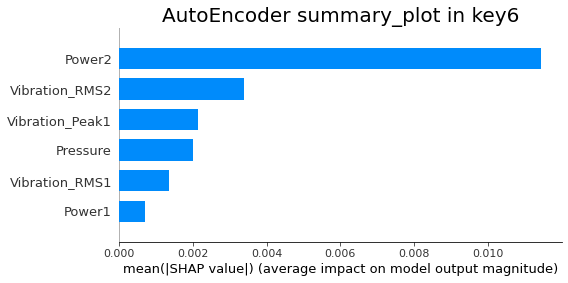

In [ ]:
for i in range(5, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'AE',param_dict = {'momentum': 0.9, 'learning_rate': 0.03,'patience':10})
  DoXAI(model=model, threshold = 5, plot_type = 0)

9.265954946625172


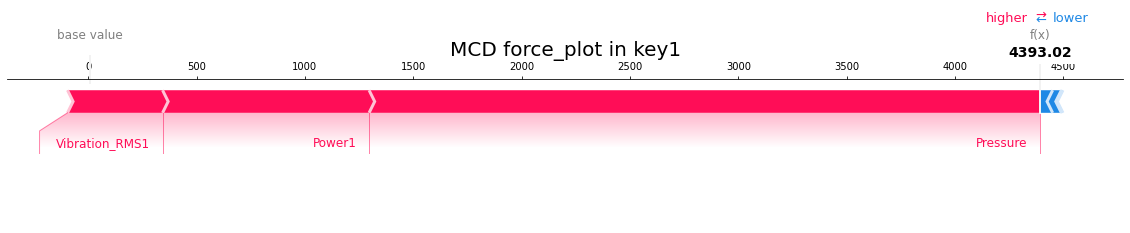

8.78049998187543


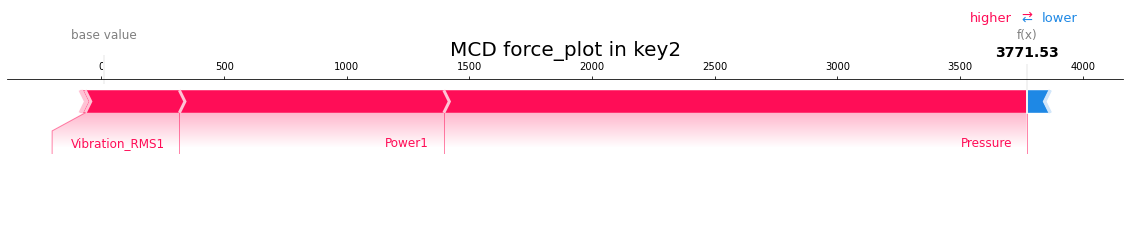

16.432887057597938


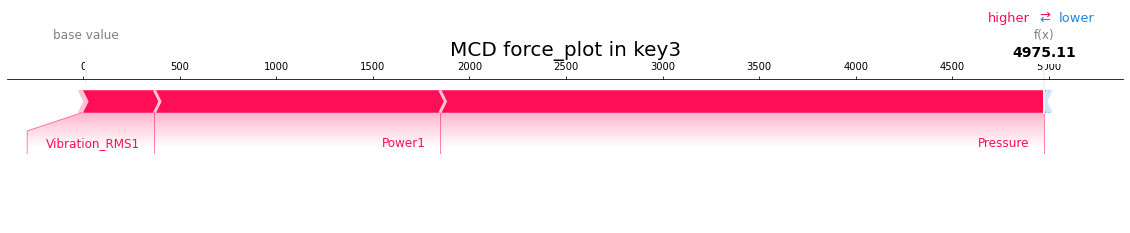

10.107622409709087


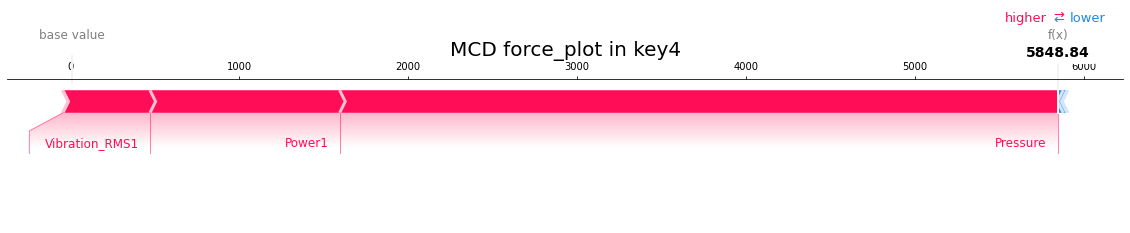

10.887304551448608


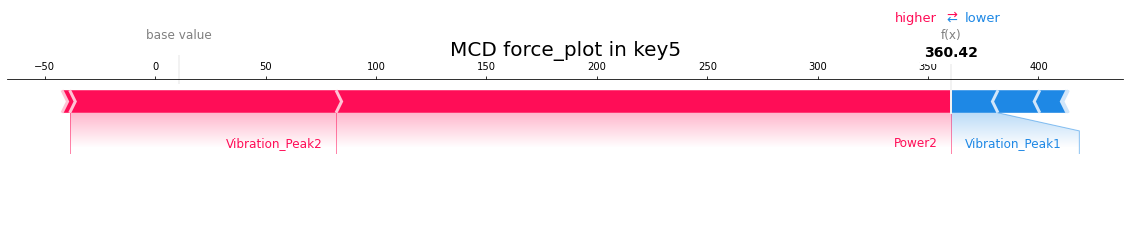

10.91780506833588


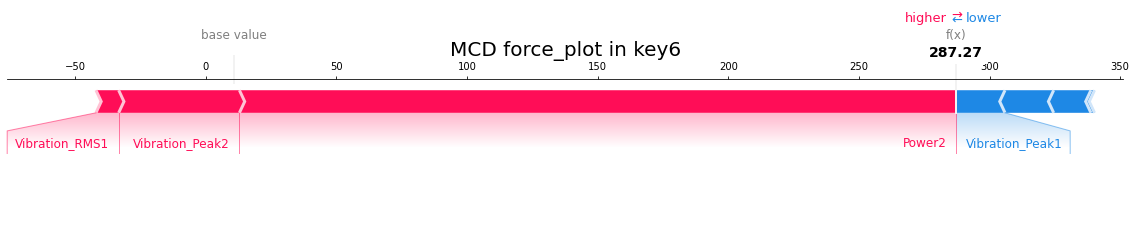

In [ ]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'MCD')
  DoXAI(model=model, threshold = 100, plot_type = 1)

1.0924056042815735


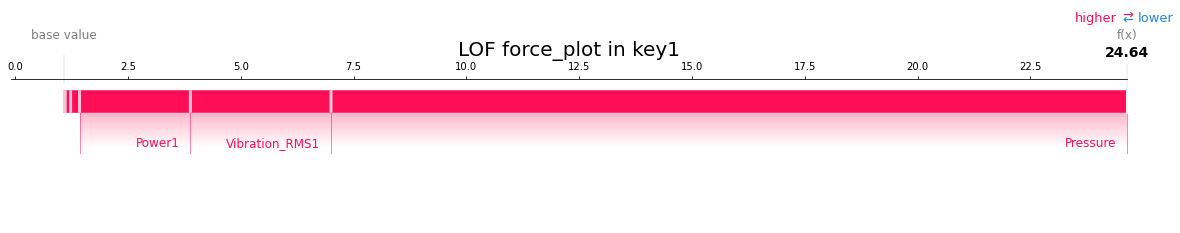

1.0551383379362858


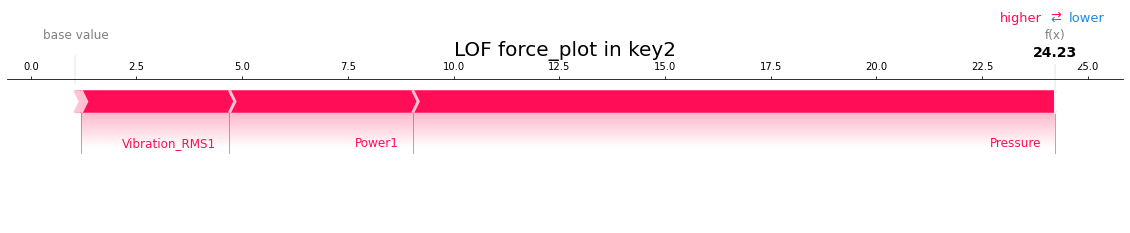

1.0917550075582014


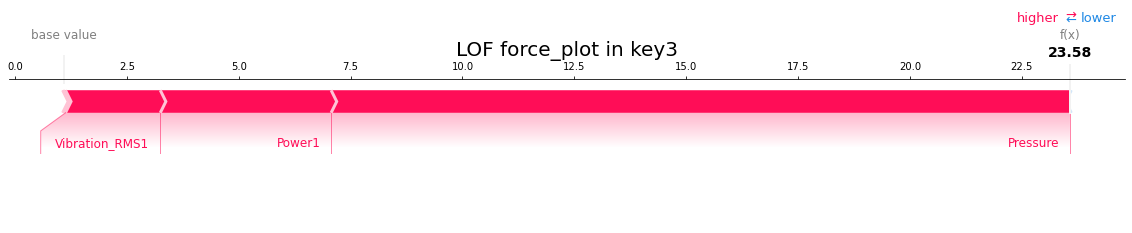

1.0837736868384082


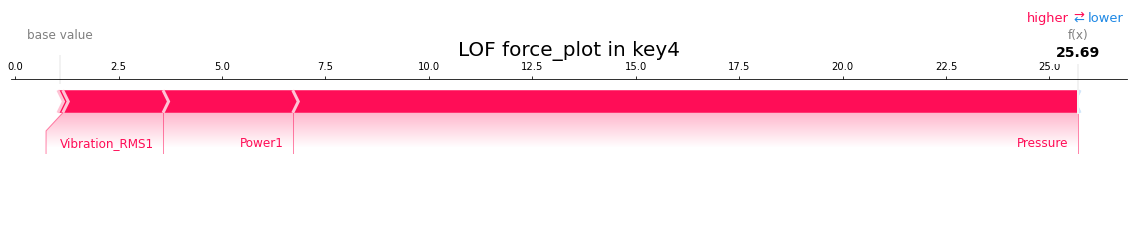

1.0775639913024126


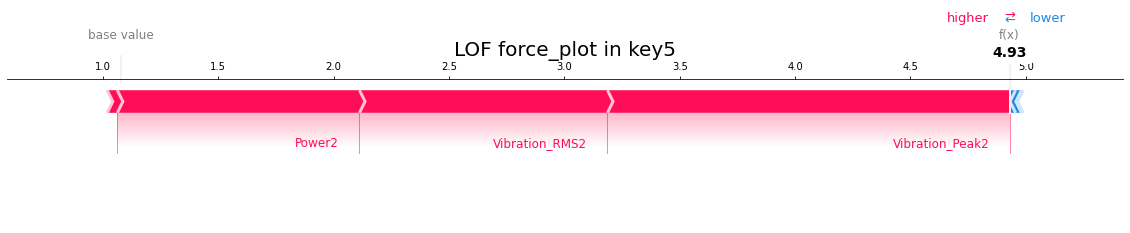

1.0675815997937164


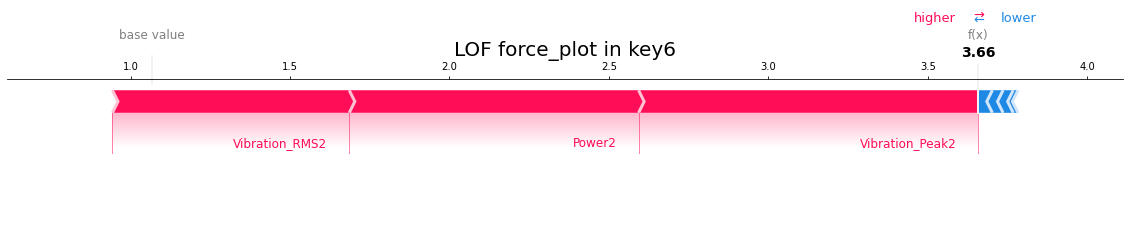

In [ ]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'LOF')
  DoXAI(model=model, threshold = 2, plot_type = 1)

5.804979416459772


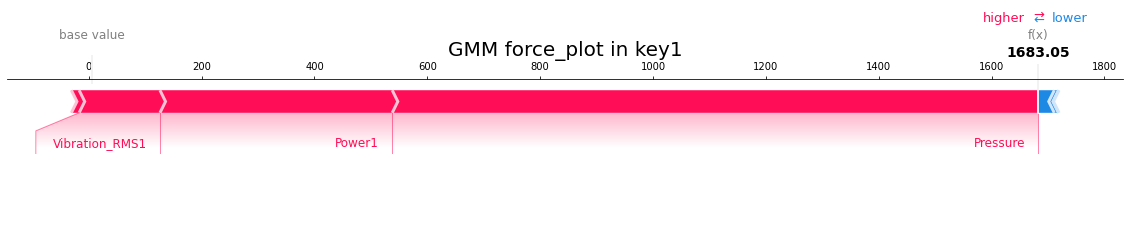

5.47309510119987


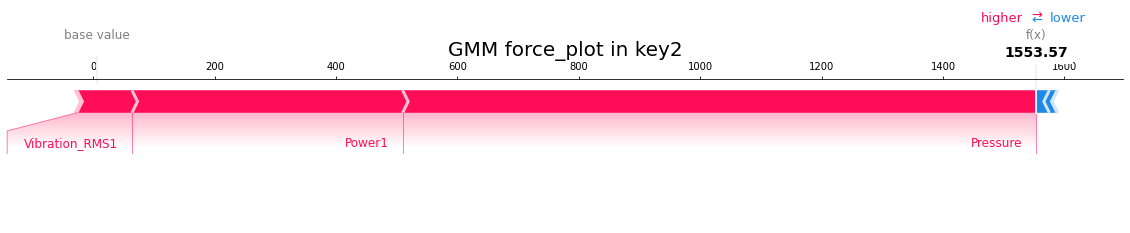

6.090968865979475


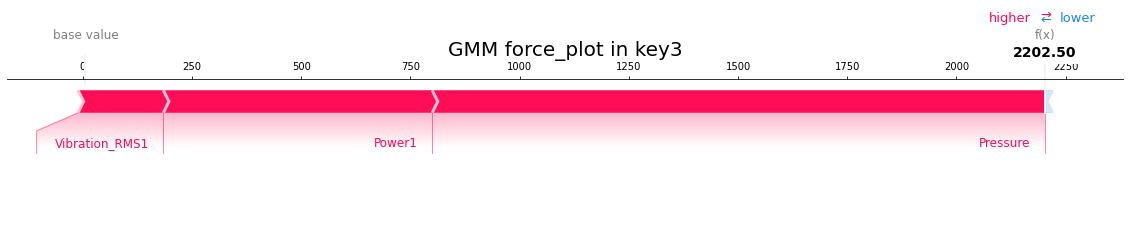

6.200868789345631


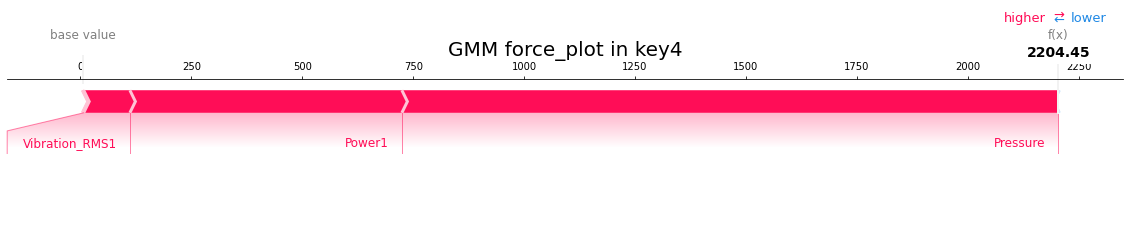

5.504914093322858


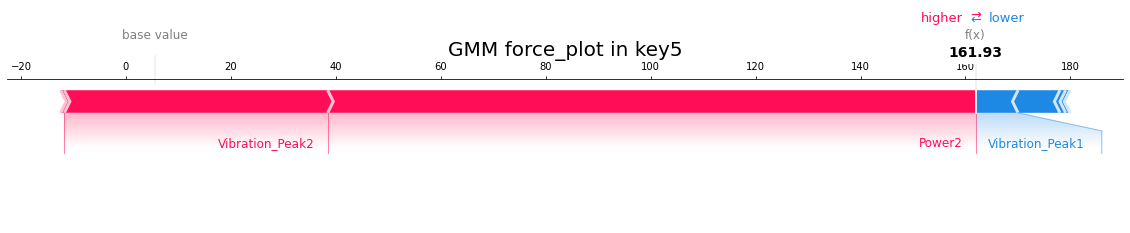

5.142889560465982


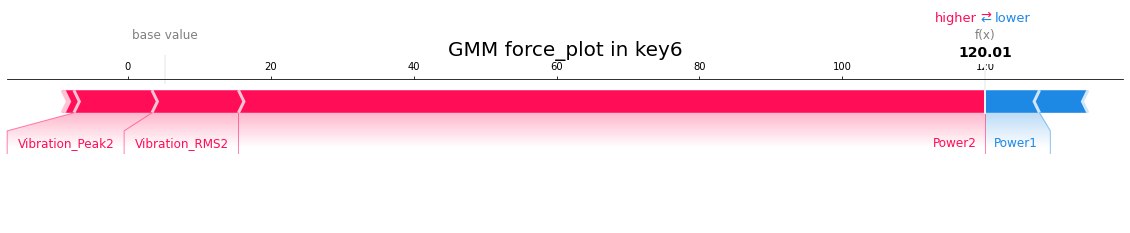

In [ ]:
for i in range(1, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'GMM')
  DoXAI(model=model, threshold = 100, plot_type = 1)

Epoch 11: early stopping
11/11 [==============================] - 0s 2ms/step
329
473/473 [==============================] - 1s 2ms/step
328
473/473 [==============================] - 1s 2ms/step
321
473/473 [==============================] - 1s 3ms/step
323
473/473 [==============================] - 1s 2ms/step
327
473/473 [==============================] - 1s 2ms/step
320
473/473 [==============================] - 1s 2ms/step
326
473/473 [==============================] - 1s 2ms/step
324
473/473 [==============================] - 1s 2ms/step
322
473/473 [==============================] - 1s 2ms/step
325
473/473 [==============================] - 1s 2ms/step
319
473/473 [==============================] - 1s 2ms/step
318
473/473 [==============================] - 1s 3ms/step
317
473/473 [==============================] - 1s 2ms/step
316
473/473 [==============================] - 1s 2ms/step
     Pressure  Vibration_RMS1    Power1  Vibration_RMS2  Vibration_Peak1  \
329 -1.000000       

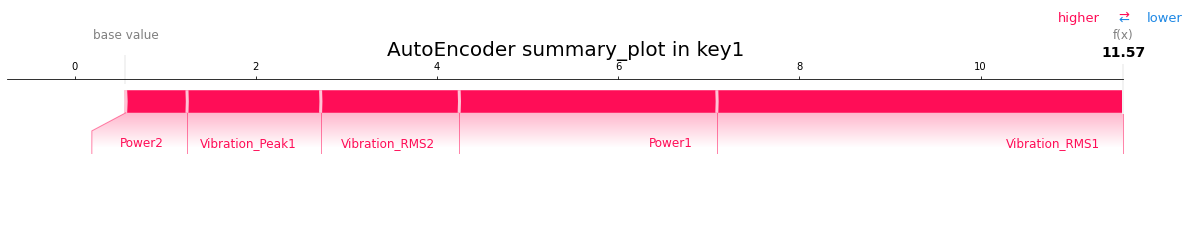

Epoch 11: early stopping
10/10 [==============================] - 0s 3ms/step
299
473/473 [==============================] - 1s 2ms/step
298
473/473 [==============================] - 1s 2ms/step
297
473/473 [==============================] - 1s 2ms/step
296
473/473 [==============================] - 1s 2ms/step
294
473/473 [==============================] - 2s 3ms/step
     Pressure    Power1  Vibration_RMS1  Vibration_Peak1  Vibration_RMS2  \
299        -1  3.112115        2.770243         0.556487        0.389551   
298        -1  2.393356        2.456550         0.461396        0.392912   
297        -1  2.472635        2.070967         0.565960        0.396152   
296        -1  2.113146        1.515488         0.338239        0.257729   
294        -1  2.152140        0.953395         0.152154        0.157450   

       Power2  Vibration_Peak2  
299  0.035407         0.000969  
298  0.030653         0.041495  
297  0.089766         0.006849  
296  0.149439         0.005452  
294  

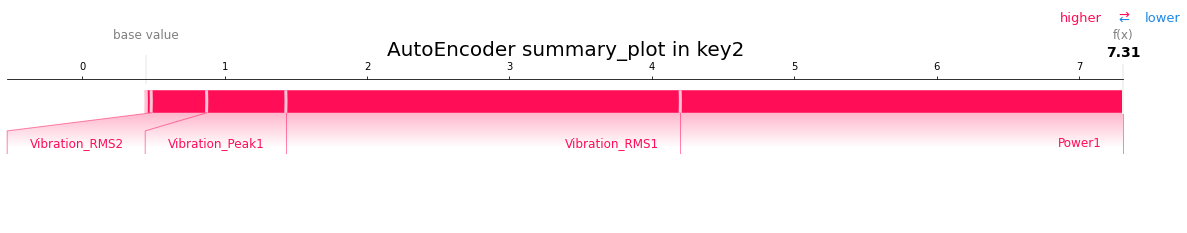

Epoch 12: early stopping
10/10 [==============================] - 0s 3ms/step
307
473/473 [==============================] - 1s 2ms/step
306
473/473 [==============================] - 1s 2ms/step
305
473/473 [==============================] - 1s 2ms/step
302
473/473 [==============================] - 1s 2ms/step
304
473/473 [==============================] - 1s 3ms/step
301
473/473 [==============================] - 1s 2ms/step
300
473/473 [==============================] - 1s 2ms/step
299
473/473 [==============================] - 1s 2ms/step
303
473/473 [==============================] - 1s 2ms/step
298
473/473 [==============================] - 1s 2ms/step
297
473/473 [==============================] - 1s 2ms/step
     Vibration_RMS1  Pressure  Vibration_Peak1    Power1  Vibration_RMS2  \
307       -1.000000  9.370123         1.285239  0.439439        0.220326   
306       -1.000000  9.275083         1.623961  0.055697        0.215993   
305       -1.000000  8.844173         1.53077

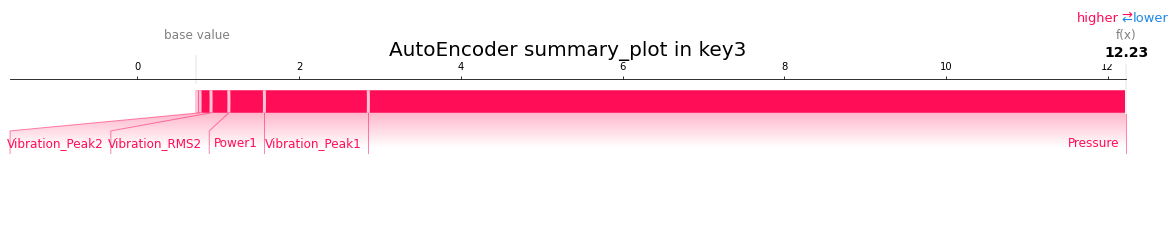

Epoch 11: early stopping
11/11 [==============================] - 0s 3ms/step
323
473/473 [==============================] - 1s 2ms/step
325
473/473 [==============================] - 1s 2ms/step
321
473/473 [==============================] - 1s 2ms/step
320
473/473 [==============================] - 1s 2ms/step
324
473/473 [==============================] - 1s 2ms/step
322
473/473 [==============================] - 1s 2ms/step
318
473/473 [==============================] - 1s 2ms/step
319
473/473 [==============================] - 1s 2ms/step
317
473/473 [==============================] - 1s 2ms/step
     Pressure    Power1  Vibration_RMS1  Vibration_RMS2  Vibration_Peak1  \
323        -1  8.381713        2.752565        0.735821         0.190384   
325        -1  8.001937        3.386999        0.685058         1.495791   
321        -1  5.896812        3.243909        0.979338         0.475994   
320        -1  3.157111        4.726945        0.893723         1.280048   
324        

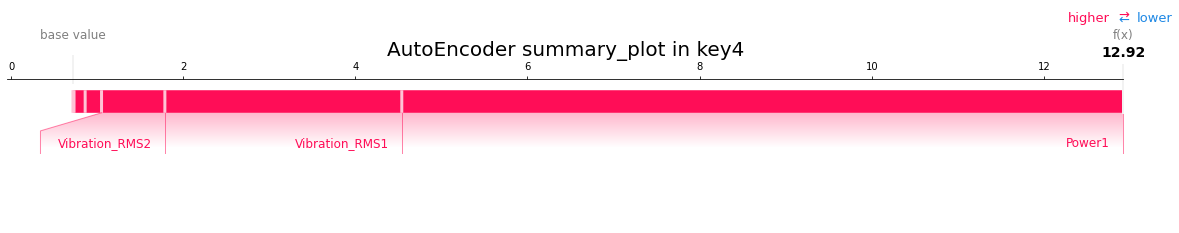

In [ ]:
for i in range(1, 5):
  SetData(key_num = i)
  model = GetModel(model_name = 'AE')
  DoXAI(model=model, threshold = 100, plot_type = 1)

Epoch 11: early stopping
8/8 [==============================] - 0s 2ms/step
249
473/473 [==============================] - 1s 2ms/step
248
473/473 [==============================] - 1s 2ms/step
241
473/473 [==============================] - 1s 2ms/step
240
473/473 [==============================] - 1s 2ms/step
239
473/473 [==============================] - 1s 2ms/step
246
473/473 [==============================] - 1s 2ms/step
243
473/473 [==============================] - 1s 2ms/step
247
473/473 [==============================] - 1s 2ms/step
238
473/473 [==============================] - 1s 3ms/step
242
473/473 [==============================] - 1s 2ms/step
244
473/473 [==============================] - 1s 2ms/step
245
473/473 [==============================] - 1s 2ms/step
231
473/473 [==============================] - 1s 2ms/step
230
473/473 [==============================] - 1s 2ms/step
229
473/473 [==============================] - 1s 2ms/step
     Vibration_Peak2  Vibration_RMS2   

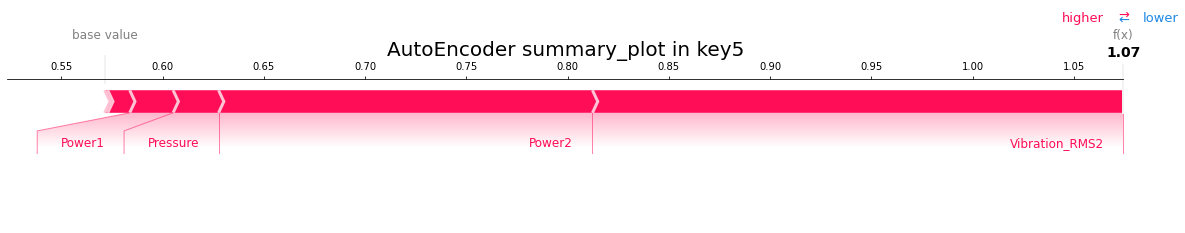

Epoch 11: early stopping
8/8 [==============================] - 0s 3ms/step
249
473/473 [==============================] - 1s 2ms/step
240
473/473 [==============================] - 1s 2ms/step
239
473/473 [==============================] - 1s 2ms/step
248
473/473 [==============================] - 1s 2ms/step
241
473/473 [==============================] - 1s 2ms/step
247
473/473 [==============================] - 1s 2ms/step
230
473/473 [==============================] - 1s 2ms/step
231
473/473 [==============================] - 1s 2ms/step
     Vibration_Peak2    Power2  Vibration_RMS2  Vibration_RMS1  \
249               -1  0.009358        0.005109        0.002681   
240               -1  0.010273        0.003010        0.001390   
239               -1  0.009925        0.003170        0.001514   
248               -1  0.010785        0.003401        0.001312   
241               -1  0.020891        0.000621        0.000677   
247               -1  0.007836        0.006464        0.

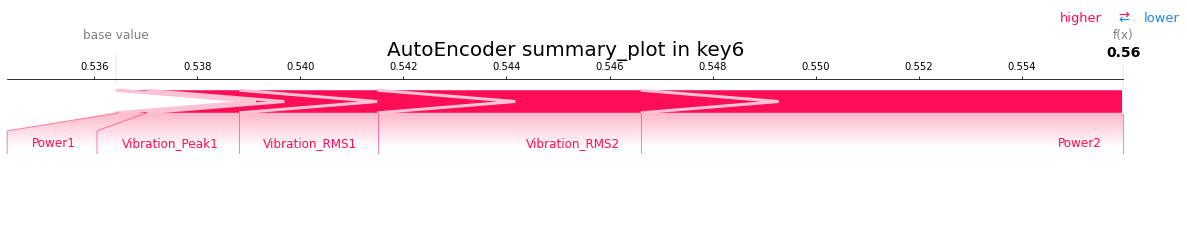

In [ ]:
for i in range(5, 7):
  SetData(key_num = i)
  model = GetModel(model_name = 'AE')
  DoXAI(model=model, threshold = 5, plot_type = 1)

# Best Model XAI

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key1.h5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key1.h5
11/11 [==============================] - 1s 3ms/step
model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key2.h5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key2.h5
10/10 [==============================] - 1s 5ms/step
model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key3.h5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key3.h5
10/10 [==============================] - 0s 3ms/step
model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key4.h5
model saved in PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key4.

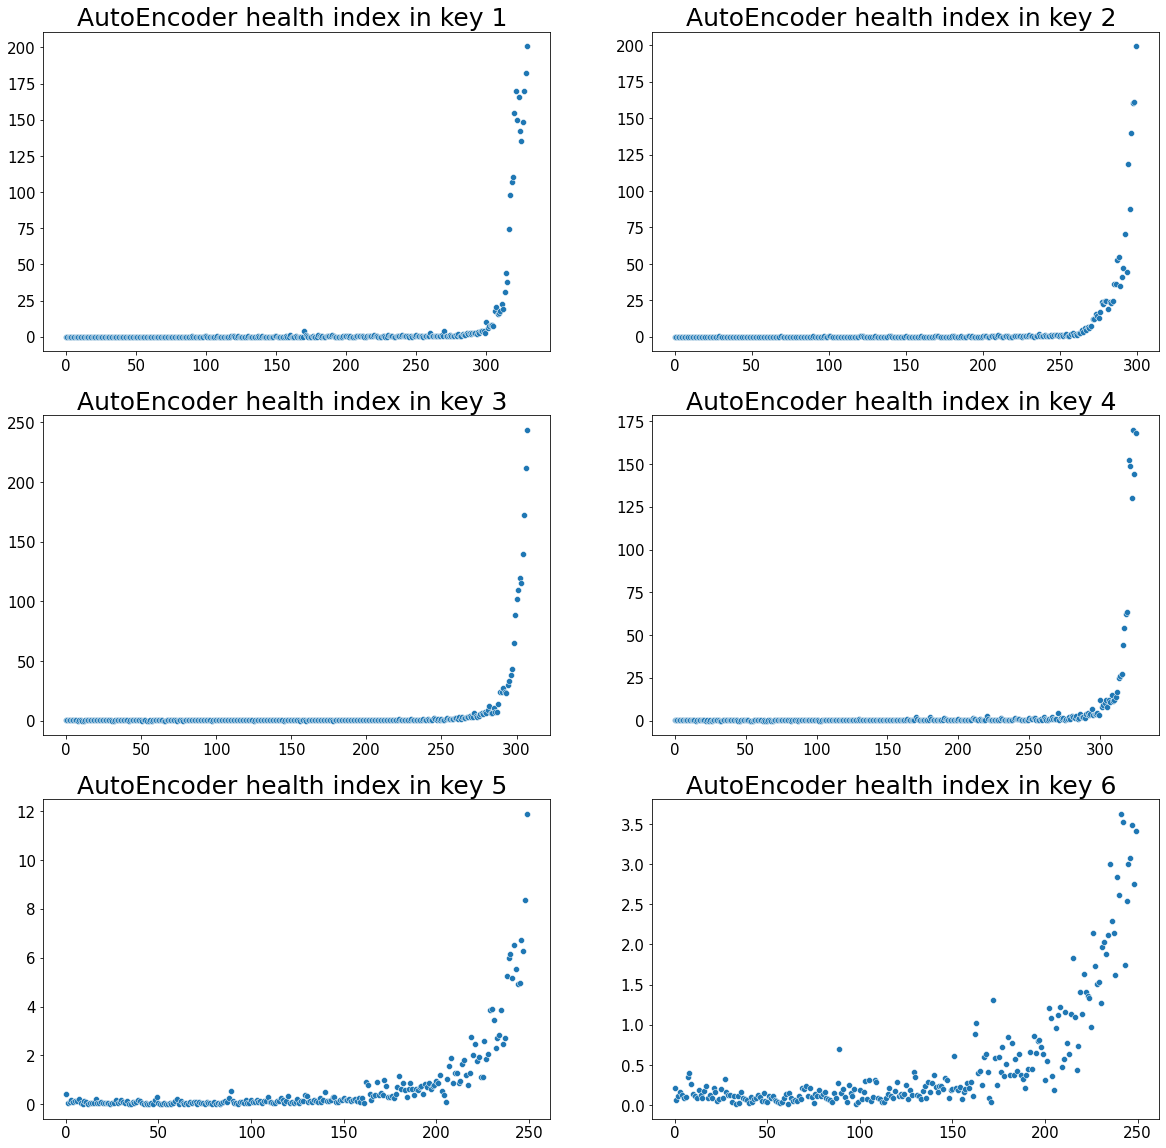

In [18]:
# scale o
plt.rcParams["figure.figsize"] = (20, 20)
for i in range(1, 7):
    plt.subplot(3,2,i)
    SetData(key_num = i)
    model = LoadBestModel('AE',key_num = i)
    SaveBestModel(model, key_num = i)
    model_name = type(model).__name__
    score = GetAnomalyScore(model)
    ShowHealthIndex(model, score, key_num = i)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
print(model)

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key1.h5
11/11 [==============================] - 0s 2ms/step
329
473/473 [==============================] - 1s 2ms/step
328
473/473 [==============================] - 1s 2ms/step
321
473/473 [==============================] - 1s 2ms/step
327
473/473 [==============================] - 1s 2ms/step
323
473/473 [==============================] - 3s 5ms/step
320
473/473 [==============================] - 1s 2ms/step
322
473/473 [==============================] - 1s 2ms/step
326
473/473 [==============================] - 1s 2ms/step
324
473/473 [==============================] - 1s 2ms/step
325
473/473 [==============================] - 1s 3ms/step
319
473/473 [==============================] - 1s 2ms/step
318
473/473 [==============================] - 1s 2ms/step
     Pressure  Vibration_RMS1    Power1  Vibration_RMS2    Power2  \
329        -1        1.032779  0.302966        0.084161  0.03536

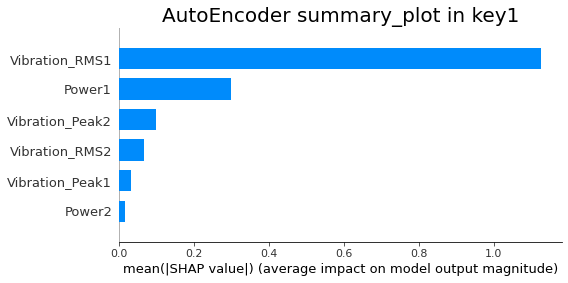

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key2.h5
10/10 [==============================] - 0s 2ms/step
299
473/473 [==============================] - 1s 2ms/step
298
473/473 [==============================] - 1s 2ms/step
297
473/473 [==============================] - 1s 2ms/step
296
473/473 [==============================] - 1s 2ms/step
294
473/473 [==============================] - 1s 2ms/step
     Pressure  Vibration_RMS1    Power1  Vibration_Peak2  Vibration_RMS2  \
299        -1        0.804372  0.670822         0.019045        0.015109   
298        -1        0.814746  0.621906         0.028046        0.017581   
297        -1        0.750893  0.514148         0.018117        0.058298   
296        -1        0.431775  0.219445         0.018267        0.001113   
294        -1        0.441260  0.302886         0.059248        0.057640   

     Vibration_Peak1    Power2  
299         0.002823  0.001947  
298         0.021023  0

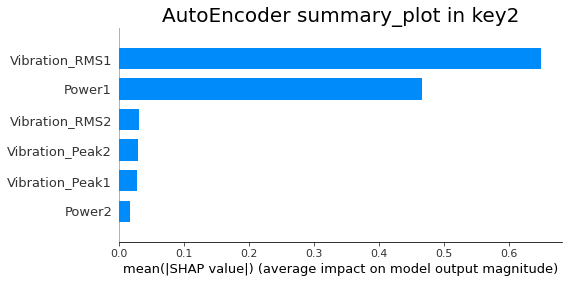

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key3.h5
10/10 [==============================] - 0s 3ms/step
307
473/473 [==============================] - 1s 2ms/step
306
473/473 [==============================] - 1s 2ms/step
305
473/473 [==============================] - 1s 2ms/step
304
473/473 [==============================] - 1s 2ms/step
302
473/473 [==============================] - 1s 2ms/step
303
473/473 [==============================] - 1s 2ms/step
301
473/473 [==============================] - 1s 2ms/step
300
473/473 [==============================] - 1s 2ms/step
     Pressure  Vibration_RMS1    Power1  Vibration_RMS2  Vibration_Peak2  \
307        -1        0.485801  0.307167        0.068844         0.030788   
306        -1        0.459266  0.303629        0.075277         0.009990   
305        -1        0.435387  0.284960        0.066837         0.015726   
304        -1        0.212227  0.170343        0.005400         0

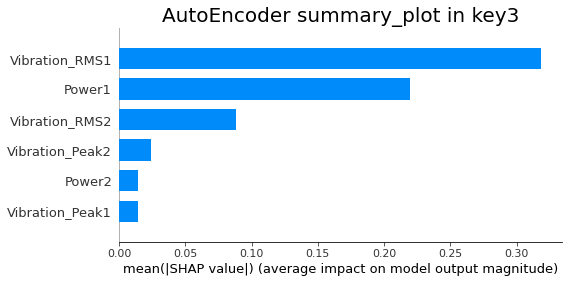

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key4.h5
11/11 [==============================] - 0s 2ms/step
323
473/473 [==============================] - 1s 2ms/step
325
473/473 [==============================] - 1s 2ms/step
320
473/473 [==============================] - 1s 2ms/step
321
473/473 [==============================] - 1s 2ms/step
324
473/473 [==============================] - 1s 2ms/step
322
473/473 [==============================] - 1s 2ms/step
     Pressure    Power1  Vibration_RMS1  Vibration_RMS2  Vibration_Peak1  \
323        -1  2.238309        1.375148        0.380545         0.217644   
325        -1  2.351834        1.426287        0.361353         0.599772   
320        -1  1.367258        1.379565        0.545632         0.675403   
321        -1  1.891876        1.359266        0.634085         0.350925   
324        -1  2.593771        1.581149        0.324524         0.552584   
322        -1  2.634799        

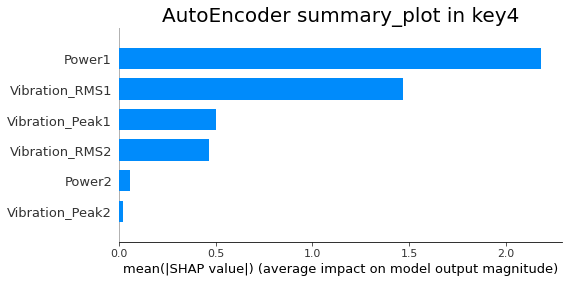

In [16]:
# Load Best Model
for i in range(1, 5):
  SetData(key_num = i)
  model = LoadBestModel('AE', key_num = i)
  DoXAI(model=model, threshold = 100, plot_type = 0)

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key5.h5
8/8 [==============================] - 0s 3ms/step
249
473/473 [==============================] - 1s 2ms/step
248
473/473 [==============================] - 1s 2ms/step
246
473/473 [==============================] - 1s 2ms/step
242
473/473 [==============================] - 1s 2ms/step
247
473/473 [==============================] - 1s 2ms/step
240
473/473 [==============================] - 1s 2ms/step
239
473/473 [==============================] - 1s 2ms/step
243
473/473 [==============================] - 1s 2ms/step
238
473/473 [==============================] - 1s 2ms/step
241
473/473 [==============================] - 1s 2ms/step
245
473/473 [==============================] - 1s 2ms/step
244
473/473 [==============================] - 1s 2ms/step
230
473/473 [==============================] - 1s 2ms/step
229
473/473 [==============================] - 1s 2ms/step
235
473/473 [====

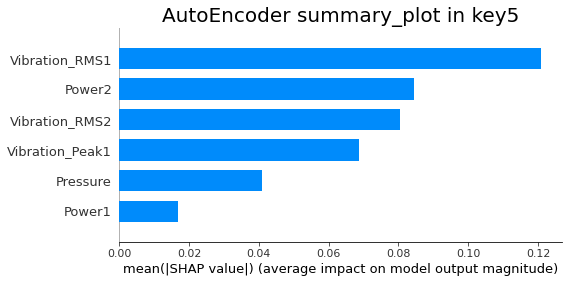

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key6.h5
8/8 [==============================] - 0s 2ms/step
241
473/473 [==============================] - 1s 2ms/step
242
473/473 [==============================] - 1s 2ms/step
247
473/473 [==============================] - 1s 2ms/step
249
473/473 [==============================] - 1s 2ms/step
246
473/473 [==============================] - 1s 2ms/step
245
473/473 [==============================] - 1s 2ms/step
235
473/473 [==============================] - 1s 2ms/step
       Power2  Vibration_Peak2  Vibration_RMS2    Power1  Pressure  \
241 -1.000000         0.395045        0.084572  0.073296  0.069966   
242  0.363488        -1.000000        0.251524  0.014582  0.121538   
247  0.526772        -1.000000        0.283032  0.073628  0.072638   
249 -1.000000         0.315592        0.134907  0.048346  0.006561   
246  0.537471        -1.000000        0.300722  0.142868  0.014170   
245  0.565

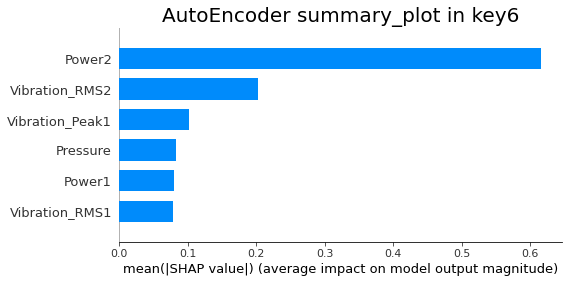

In [19]:
# Load Best Model
for i in range(5, 7):
  SetData(key_num = i)
  model = LoadBestModel('AE', key_num = i)
  DoXAI(model=model, threshold = 3, plot_type = 0)

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key1.h5
11/11 [==============================] - 0s 2ms/step
329
473/473 [==============================] - 1s 2ms/step
328
473/473 [==============================] - 1s 2ms/step
321
473/473 [==============================] - 1s 2ms/step
327
473/473 [==============================] - 1s 2ms/step
323
473/473 [==============================] - 1s 2ms/step
320
473/473 [==============================] - 1s 2ms/step
322
473/473 [==============================] - 1s 2ms/step
326
473/473 [==============================] - 1s 2ms/step
324
473/473 [==============================] - 1s 2ms/step
325
473/473 [==============================] - 1s 2ms/step
319
473/473 [==============================] - 1s 2ms/step
318
473/473 [==============================] - 1s 2ms/step
     Pressure  Vibration_RMS1    Power1  Vibration_RMS2    Power2  \
329        -1        1.032779  0.302966        0.084161  0.03536

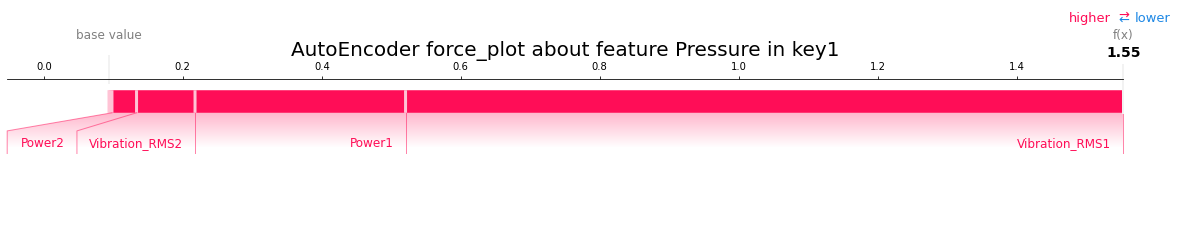

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key2.h5
10/10 [==============================] - 0s 2ms/step
299
473/473 [==============================] - 1s 2ms/step
298
473/473 [==============================] - 1s 2ms/step
297
473/473 [==============================] - 1s 2ms/step
296
473/473 [==============================] - 2s 5ms/step
294
473/473 [==============================] - 1s 2ms/step
     Pressure  Vibration_RMS1    Power1  Vibration_Peak2  Vibration_RMS2  \
299        -1        0.804372  0.670822         0.019045        0.015109   
298        -1        0.814746  0.621906         0.028046        0.017581   
297        -1        0.750893  0.514148         0.018117        0.058298   
296        -1        0.431775  0.219445         0.018267        0.001113   
294        -1        0.441260  0.302886         0.059248        0.057640   

     Vibration_Peak1    Power2  
299         0.002823  0.001947  
298         0.021023  0

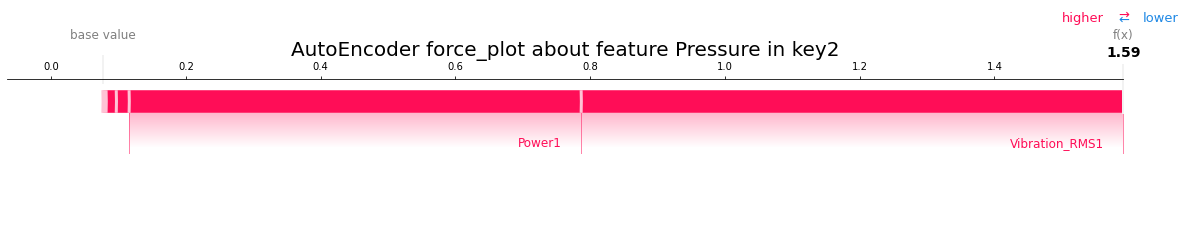

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key3.h5
10/10 [==============================] - 0s 2ms/step
307
473/473 [==============================] - 2s 5ms/step
306
473/473 [==============================] - 1s 2ms/step
305
473/473 [==============================] - 1s 2ms/step
304
473/473 [==============================] - 1s 2ms/step
302
473/473 [==============================] - 1s 2ms/step
303
473/473 [==============================] - 2s 4ms/step
301
473/473 [==============================] - 1s 2ms/step
300
473/473 [==============================] - 1s 2ms/step
     Pressure  Vibration_RMS1    Power1  Vibration_RMS2  Vibration_Peak2  \
307        -1        0.485801  0.307167        0.068844         0.030788   
306        -1        0.459266  0.303629        0.075277         0.009990   
305        -1        0.435387  0.284960        0.066837         0.015726   
304        -1        0.212227  0.170343        0.005400         0

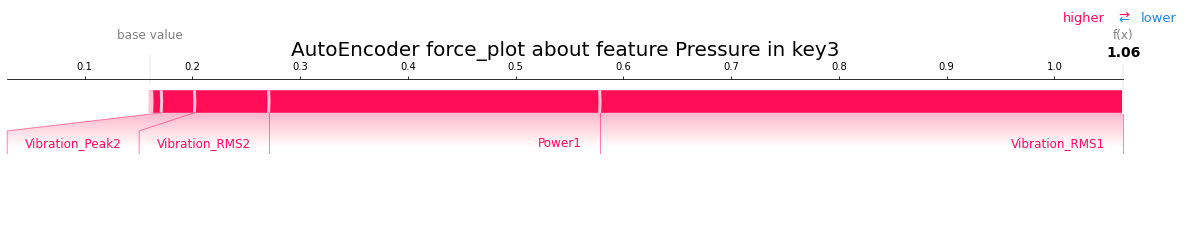

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key4.h5
11/11 [==============================] - 0s 2ms/step
323
473/473 [==============================] - 1s 2ms/step
325
473/473 [==============================] - 1s 2ms/step
320
473/473 [==============================] - 1s 2ms/step
321
473/473 [==============================] - 1s 2ms/step
324
473/473 [==============================] - 1s 2ms/step
322
473/473 [==============================] - 1s 2ms/step
     Pressure    Power1  Vibration_RMS1  Vibration_RMS2  Vibration_Peak1  \
323        -1  2.238309        1.375148        0.380545         0.217644   
325        -1  2.351834        1.426287        0.361353         0.599772   
320        -1  1.367258        1.379565        0.545632         0.675403   
321        -1  1.891876        1.359266        0.634085         0.350925   
324        -1  2.593771        1.581149        0.324524         0.552584   
322        -1  2.634799        

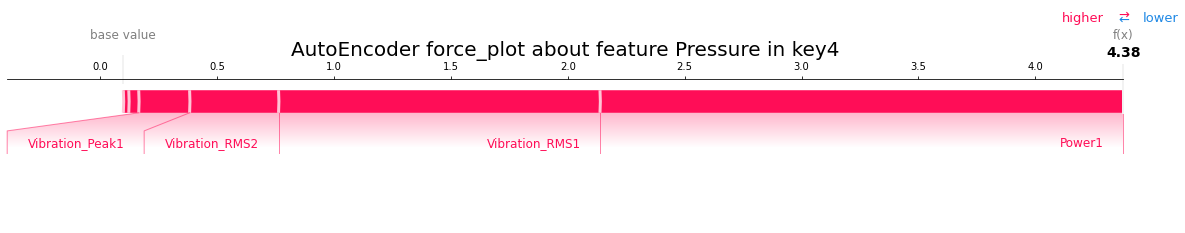

In [20]:
# Load Best Model
for i in range(1, 5):
  SetData(key_num = i)
  model = LoadBestModel('AE', key_num = i)
  DoXAI(model=model, threshold = 100, plot_type = 1, sample_index = 0)

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key5.h5
8/8 [==============================] - 0s 2ms/step
249
473/473 [==============================] - 1s 2ms/step
248
473/473 [==============================] - 1s 2ms/step
246
473/473 [==============================] - 1s 2ms/step
242
473/473 [==============================] - 1s 2ms/step
247
473/473 [==============================] - 1s 2ms/step
240
473/473 [==============================] - 1s 2ms/step
239
473/473 [==============================] - 1s 2ms/step
243
473/473 [==============================] - 1s 2ms/step
238
473/473 [==============================] - 1s 2ms/step
241
473/473 [==============================] - 1s 2ms/step
245
473/473 [==============================] - 1s 2ms/step
244
473/473 [==============================] - 1s 2ms/step
230
473/473 [==============================] - 1s 2ms/step
229
473/473 [==============================] - 1s 2ms/step
235
473/473 [====

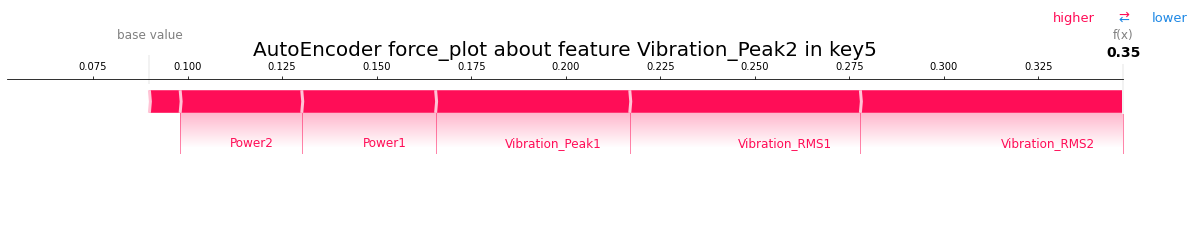

model load from PATH : /content/drive/MyDrive/bistelligence/BISTelligence/src/model/best_model/AE_key6.h5
8/8 [==============================] - 0s 2ms/step
241
473/473 [==============================] - 1s 2ms/step
242
473/473 [==============================] - 1s 2ms/step
247
473/473 [==============================] - 1s 2ms/step
249
473/473 [==============================] - 1s 2ms/step
246
473/473 [==============================] - 1s 2ms/step
245
473/473 [==============================] - 1s 2ms/step
235
473/473 [==============================] - 1s 2ms/step
       Power2  Vibration_Peak2  Vibration_RMS2    Power1  Pressure  \
241 -1.000000         0.395045        0.084572  0.073296  0.069966   
242  0.363488        -1.000000        0.251524  0.014582  0.121538   
247  0.526772        -1.000000        0.283032  0.073628  0.072638   
249 -1.000000         0.315592        0.134907  0.048346  0.006561   
246  0.537471        -1.000000        0.300722  0.142868  0.014170   
245  0.565

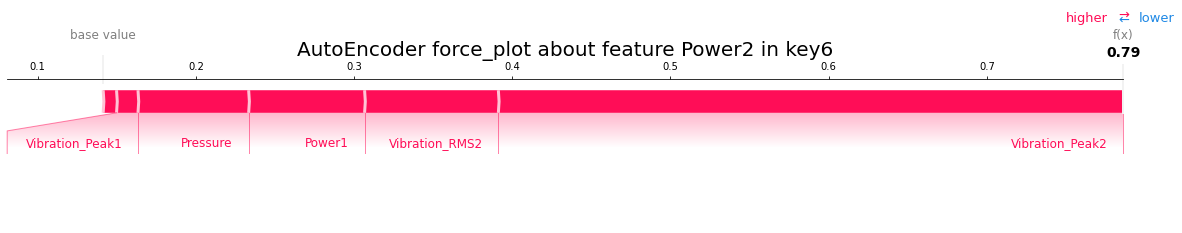

In [21]:
# Load Best Model
for i in range(5, 7):
  SetData(key_num = i)
  model = LoadBestModel('AE', key_num = i)
  DoXAI(model=model, threshold = 3, plot_type = 1, sample_index = 0)